# Using archived and newly generated RXTE light curves

## Learning Goals

By the end of this tutorial, you will:

- Know how to find and use observation tables hosted by HEASARC.
- Be able to search for RXTE observations of a named source.
- Understand how to access RXTE light curves stored in the HEASARC AWS S3 bucket.
- Be capable of downloading and visualizing retrieved light curves.
- Know how to generate new RXTE-PCA light curves with:
  - Custom energy bounds.
  - Higher temporal resolution than archived products.
- Use 'Continuous Wavelet Transform' (CWT) peak finding to identify possible bursts.

## Introduction

This notebook is intended to demonstrate how you can use Rossi Timing X-ray Explorer ([RXTE](https://heasarc.gsfc.nasa.gov/docs/xte/rxte.html)) data to examine
the temporal variation of a source's X-ray emission across a wide energy range. We start by identifying and
exploring archived RXTE light curves for our source of interest and move on to generating **new** light curves
from raw RXTE Proportional Counter Array (PCA) data.

RXTE was a high-energy mission that provided very high temporal resolution, moderate spectral resolution,
observations across a wide energy band (~2–250 keV).

The satellite hosted three instruments:
- **PCA** - *Proportional Counter Array*; a set of five co-aligned proportional counter units (PCU), sensitive in the 2–60 keV energy band. Collimated ~1 degree full-width half-maximum (FWHM) field-of-view (FoV).
- **HEXTE** - *High-Energy X-ray Timing Experiment*; a pair of scintillation-counter clusters, sensitive in the 15–250 keV energy band. Collimated ~1 degree FWHM FoV.
- **ASM** - *All Sky Monitor*; a set of three coded-mask instruments that covered a significant fraction of the sky with each observation (each camera had a 6 x 90 degree FoV). Sensitive in the 2–12 keV energy band.

The **PCA** and **HEXTE** instruments had maximum temporal resolutions of $1 \mu \rm{s}$ and $8 \mu \rm{s}$ respectively.

Our demonstration is only going to use data from the PCA and HEXTE instruments, and we will only generate new light curves from the PCA instrument.

Though neither PCA nor HEXTE had any imaging capability (they collected photons from their whole FoV without any further spatial information), their time resolution was such that they were very well suited to observations of pulsars; rotating neutron stars with high-energy emission that can vary on the millisecond scale.

We're going to use a particularly notable pulsar in a low-mass X-ray binary (LMXB) system discovered using RXTE as the subject of our demonstration, '**IGR J17480–2446**' or '**T5X2**'.

Though it actually rotates quite slowly for a pulsar ("only" ~11 times per second), it displays a number of very interesting behaviors; these include 'bursts' of emission caused by infalling gas from its binary companion, and X-ray emission caused by sustained thermonuclear reactions from a large build-up of material possible because of the high accretion rate from its companion.

This behavior had been predicted and modeled, but the first real example was identified in RXTE observations of T5X2, see [M. Linares et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012ApJ...748...82L/abstract) for full analysis and results.


### Inputs

- The name of the source we've chosen for the demonstration; **IGR J17480–2446** or **T5X2**.

### Outputs

- Visualizations of archived RXTE-PCA and HEXTE light curves.
- Newly generated RXTE-PCA light curves within a custom energy band.
- Newly generated RXTE-PCA light curves with a higher time resolution than the archived data products.

### Runtime

As of 21st January 2026, this notebook takes ~25 minutes to run to completion on Fornax, using the 'small' server with 8GB RAM / 2 cores.

## Imports & Environments

In [1]:
import contextlib
import glob
import multiprocessing as mp
import os
from pprint import pprint
from typing import List, Tuple, Union

import heasoftpy as hsp
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import unique
from astropy.time import Time
from astropy.units import Quantity
from astroquery.heasarc import Heasarc
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter
from s3fs import S3FileSystem
from scipy.signal import find_peaks_cwt
from xga.products import AggregateLightCurve, LightCurve

/opt/envs/heasoft/lib/python3.12/site-packages/xga/utils.py:39: DeprecationWarning: The XGA 'find_all_wcs' function should be imported from imagetools.misc, in the future it will be removed from utils.
  warn(message, DeprecationWarning)
/opt/envs/heasoft/lib/python3.12/site-packages/xga/utils.py:619: UserWarning: SAS_DIR environment variable is not set, unable to verify SAS is present on system, as such all functions in xga.sas will not work.
  warn("SAS_DIR environment variable is not set, unable to verify SAS is present on system, as such "
/opt/envs/heasoft/lib/python3.12/site-packages/xga/__init__.py:6: UserWarning: This is the first time you've used XGA; to use most functionality you will need to configure /home/jovyan/.config/xga/xga.cfg to match your setup, though you can use product classes regardless.
  from .utils import xga_conf, CENSUS, OUTPUT, NUM_CORES, XGA_EXTRACT, BASE_XSPEC_SCRIPT, CROSS_ARF_XSPEC_SCRIPT, \
/opt/envs/heasoft/lib/python3.12/site-packages/xga/products/r

/opt/envs/heasoft/lib/python3.12/site-packages/xga/products/relation.py:12: DeprecationWarning: `scipy.odr` is deprecated as of version 1.17.0 and will be removed in SciPy 1.19.0. Please use `https://pypi.org/project/odrpack/` instead.
  import scipy.odr as odr


## Global Setup

### Functions

In [2]:
def rxte_lc_inst_band_obs(path: str) -> Tuple[str, Quantity, str]:
    """
    A simple function to extract the RXTE instrument, energy band, and ObsID from a
    light curve file with a name that follows the RXTE standards.

    :param str path: The path to the file, either a relative/absolute path or just
        the file name will be accepted.
    :return: The instrument name, the energy band, and the ObsID
    :rtype: Tuple[str, Quantity, str]
    """

    # Ensure that we just have the file name, and not any full-path
    #  directory information
    file_name = os.path.basename(path)

    # First check, is this file from PCA or one of the HEXTE clusters?
    if file_name[:2].lower() == "xp":
        file_inst = "PCA"
    elif file_name[:2].lower() == "xh":
        file_inst = "HEXTE"
    else:
        raise ValueError(
            "Passed file name does not appear to be in the RXTE standard format."
        )

    # If HEXTE, which cluster?
    if file_inst == "HEXTE":
        file_clust_id = file_name.split("_")[-1].split(".")[0][1]

        # Just add the information to the instrument name
        file_inst = file_inst + "-" + file_clust_id

    # Extract ObsID from the file name
    file_oi = file_name.split("_")[0][2:]

    # Convert the energy band code in the name to real numbers!
    file_en_code = file_name.split("_")[-1].split(".")[0][-1]
    if file_inst == "PCA":
        file_en_band = PCA_EN_BANDS[file_en_code]
    else:
        file_en_band = HEXTE_EN_BANDS[file_en_code]

    return file_inst, file_en_band, file_oi


def pca_pcu_check(sel_pcu: Union[str, int, List[Union[str, int]]]) -> str:
    """
    A simple validation function, that will normalize user-supplied sets of RXTE-PCA
    PCU IDs to a string format that can be passed to RXTE-PCA HEASoft tasks.

    :param str/int/List[Union[str, int]] sel_pcu: User-supplied RXTE-PCA PCU IDs in
        one of several allowable formats.
    :return: User-selected RXTE-PCA PCU IDs in a normalized format suitable for passing
        to RXTE-PCA HEASoft tasks.
    :rtype: str
    """
    # Make a joined string of all allowed PCU IDs - useful in error messages
    all_pcu_str = ", ".join([str(pcu_id) for pcu_id in ALLOWED_PCA_PCU_IDS])

    # Formats allowed for the 'sel_pcu' argument are:
    #  - Single string (convertible to integer) or integer
    #  - List of strings (convertible to integer) or integers
    #  - String "ALL"
    # This set of if/elif statements both validates the input types, makes sure that
    #  the contents are valid PCU IDs, and converts to the output format
    if isinstance(sel_pcu, int) and sel_pcu in ALLOWED_PCA_PCU_IDS:
        sel_pcu = str(sel_pcu)
    elif isinstance(sel_pcu, int) or (
        isinstance(sel_pcu, str)
        and sel_pcu != "ALL"
        and int(sel_pcu) not in ALLOWED_PCA_PCU_IDS
    ):
        raise ValueError(
            f"The value passed to the 'sel_pcu' argument is not a valid "
            f"PCA PCU ID, pass one of the following; {all_pcu_str}."
        )
    elif isinstance(sel_pcu, list) and not all(
        [int(en) in ALLOWED_PCA_PCU_IDS for en in sel_pcu]
    ):
        raise ValueError(
            f"The list passed to the 'sel_pcu' argument contains invalid "
            f"PCU IDs, please only use the following values; {all_pcu_str}."
        )
    elif isinstance(sel_pcu, list):
        sel_pcu = ",".join([str(pcu_id) for pcu_id in sel_pcu])

    return sel_pcu


def process_rxte_pca(cur_obs_id: str, out_dir: str, obj_coord: SkyCoord):
    """
    A wrapper for the HEASoftPy pcaprepobsid task, which is used to prepare and process
    RXTE-PCA observation data, and is the first step toward creating new RXTE-PCA
    data products. The wrapper is primarily to enable the use of multiprocessing.

    Both Standard 1 and Standard 2 data modes will be processed.

    The tasks that pcaprepobsid runs are:

        1. xtefilt - create XTE filter file (*.xfl)
        2. xteprefilter - create prefilter-style filter file (*.mkf)
        3. pcaprepfile1 - prepare each Standard1 file for analysis
           - pcadeadcalc1 - calculate dead time quantities
        3. pcaprepfile2 - prepare each Standard2 file for analysis
           - pcadeadcalc2 - calculate dead time quantities
           - pcabackest - estimate PCA background

    :param str cur_obs_id: The ObsID of the RXTE observation to be processed.
    :param str out_dir: The directory where output files should be written.
    :param SkyCoord obj_coord: The coordinate of the target source.
    :return: A tuple containing the processed ObsID, the log output of the
        pipeline, and a boolean flag indicating success (True) or failure (False).
    :rtype: Tuple[str, hsp.core.HSPResult, bool]
    """

    # Makes sure the specified output directory exists.
    os.makedirs(out_dir, exist_ok=True)

    # Using dual contexts, one that moves us into the output directory for the
    #  duration, and another that creates a new set of HEASoft parameter files (so
    #  there are no clashes with other processes).
    with contextlib.chdir(out_dir), hsp.utils.local_pfiles_context():

        # The processing/preparation stage of any X-ray telescope's data is the most
        #  likely to go wrong, and we use a Python try-except as an automated way to
        #  collect ObsIDs that had an issue during processing.
        try:
            out = hsp.pcaprepobsid(
                indir=os.path.join(ROOT_DATA_DIR, cur_obs_id),
                outdir=out_dir,
                ra=obj_coord.ra.value,
                dec=obj_coord.dec.value,
            )
            task_success = True

        except hsp.HSPTaskException as err:
            task_success = False
            out = str(err)

    return cur_obs_id, out, task_success


def gen_pca_gti(cur_obs_id: str, out_dir: str, rel_filt: str) -> hsp.core.HSPResult:
    """
    A wrapper for the HEASoftPy maketime task, which helps enable multiprocessing runs
    of this task. The maketime task is used to generate good time interval (GTI) files
    based on the input filter expression. This is necessary for RXTE-PCA data that
    is being re-processed from scratch

    :param str cur_obs_id: The ObsID of the RXTE observation to be processed.
    :param str out_dir: The directory where output files should be written.
    :param str rel_filt: Filtering expression to be applied to the RXTE-PCA data.
    :return: HEASoftPy result object output from this run of 'maketime'.
    :rtype: hsp.core.HSPResult
    """
    # Find the filter file that was created by pcaprepobsid
    filt_file = glob.glob(out_dir + "/FP_*.xfl")[0]

    with contextlib.chdir(out_dir), hsp.utils.local_pfiles_context():
        out = hsp.maketime(
            infile=filt_file,
            outfile=f"rxte-pca-{cur_obs_id}-gti.fits",
            expr=rel_filt,
            name="NAME",
            value="VALUE",
            time="TIME",
            compact="NO",
            clobber=True,
        )

    return out


def gen_pca_s2_spec_resp(
    cur_obs_id: str,
    out_dir: str,
    sel_pcu: Union[str, List[Union[str, int]], int] = "ALL",
) -> hsp.core.HSPResult:
    """
    A wrapper for the HEASoftPy pcaextspect2 task, which will generate RXTE-PCA spectra
    and supporting files. In this case we are only interested in the response files to
    help us convert between Standard 2 channels and energy, so the wrapper will
    remove the actual source and background spectral files after generation.

    The user can specify which RXTE-PCA PCUs are to be used when generating the files.

    :param str cur_obs_id: The ObsID of the RXTE observation to be processed.
    :param str out_dir: The directory where output files should be written.
    :param str/int/List[Union[str, int]] sel_pcu: The RXTE-PCA PCUs to be used when
        generating the spectral responses. Pass either a single string or integer
        representing the PCU ID, or a list of strings or integers representing the
        PCU IDs. Defaults to 'ALL'.
    :return: HEASoftPy result object output from this run of 'pcaextspect2'.
    :rtype: hsp.core.HSPResult
    """
    # Runs the PCU validation function
    sel_pcu = pca_pcu_check(sel_pcu)

    # Again locate the filter file that was created by pcaprepobsid
    filt_file = glob.glob(out_dir + "/FP_*.xfl")[0]

    # Specify the name of the response file that is the output of this function
    rsp_out = f"rxte-pca-pcu{sel_pcu.replace(',', '_')}-{cur_obs_id}.rsp"

    with contextlib.chdir(out_dir), hsp.utils.local_pfiles_context():
        out = hsp.pcaextspect2(
            src_infile="@FP_dtstd2.lis",
            bkg_infile="@FP_dtbkg2.lis",
            src_phafile="remove_sp.fits",
            bkg_phafile="remove_bsp.fits",
            respfile=rsp_out,
            gtiandfile=f"rxte-pca-{cur_obs_id}-gti.fits",
            pculist=sel_pcu,
            layerlist="ALL",
            filtfile=filt_file,
        )

        # No care was taken generating the spectra themselves, as this function was
        #  only intended to provide response files. As such we delete the spectra
        os.remove("remove_sp.fits")
        os.remove("remove_bsp.fits")

    return out


def gen_pca_s1_light_curve(
    cur_obs_id: str,
    out_dir: str,
    time_bin_size: Quantity = Quantity(2, "s"),
    sel_pcu: Union[str, List[Union[str, int]], int] = "ALL",
) -> hsp.core.HSPResult:
    """
    A wrapper for the HEASoftPy pcaextlc1 task, which generates a light curve from
    RXTE-PCA Standard 1 data.

    The Standard 1 data mode is less commonly used than Standard 2, and has the
    significant downside of not providing any spectral information. HOWEVER, it does
    allow the user to create light curves with time bin sizes less than 16 seconds.

    If the desired time bin size is greater than or equal to 16 seconds, then the
    Standard 2 data mode, and the gen_pca_s2_light_curve function, should be
    used instead.

    :param str cur_obs_id: The ObsID of the RXTE observation to be processed.
    :param str out_dir: The directory where output files should be written.
    :param Quantity time_bin_size: Bin size (in units of time) used to generate the
        Standard 1 light curve. Defaults to 2 seconds, and values greater than
        or equal to 16 seconds are invalid (instead use gen_pca_s2_light_curve).
    :param str/int/List[Union[str, int]] sel_pcu: The RXTE-PCA PCUs to be used when
        generating the spectral responses. Pass either a single string or integer
        representing the PCU ID, or a list of strings or integers representing the
        PCU IDs. Defaults to 'ALL'.
    :return: HEASoftPy result object output from this run of 'pcaextlc1'.
    :rtype: hsp.core.HSPResult
    """
    # Checking the validity of the passed time bin size - for Standard 1 data the
    #  background becomes slightly invalid when using time bins larger than 16 seconds.
    # Besides, the user should WANT to use Standard 2 for those bin sizes because
    #  then you get spectral information back
    if time_bin_size >= Quantity(16, "s"):
        raise ValueError(
            "Time bin sizes greater than 16 seconds are not recommended for use with "
            "Standard-1 RXTE PCA analysis."
        )
    else:
        time_bin_size = time_bin_size.to("s").value

    # Running PCU selection validity check
    sel_pcu = pca_pcu_check(sel_pcu)

    # Setting up the light curve file name - no energy information is included in this
    #  file name because the Standard 1 data mode does not provide spectral information.
    lc_out = (
        f"rxte-pca-pcu{sel_pcu.replace(',', '_')}-{cur_obs_id}-"
        f"enALL-tb{time_bin_size}s-lightcurve.fits"
    )

    with contextlib.chdir(out_dir), hsp.utils.local_pfiles_context():
        # Running pcaextlc1
        out = hsp.pcaextlc1(
            src_infile="@FP_dtstd1.lis",
            bkg_infile="@FP_dtbkg2.lis",
            outfile=lc_out,
            gtiandfile=f"rxte-pca-{cur_obs_id}-gti.fits",
            chmin="INDEF",
            chmax="INDEF",
            pculist=sel_pcu,
            layerlist="ALL",
            binsz=time_bin_size,
        )

    return out


def gen_pca_s2_light_curve(
    cur_obs_id: str,
    out_dir: str,
    lo_en: Quantity,
    hi_en: Quantity,
    rsp_path: str,
    time_bin_size: Quantity = Quantity(16, "s"),
    sel_pcu: Union[str, List[Union[str, int]], int] = "ALL",
) -> hsp.core.HSPResult:
    """
    A wrapper for the HEASoftPy pcaextlc2 task, which generates a light curve from
    RXTE-PCA Standard 2 data.

    The Standard 2 data mode is the default for most RXTE-PCA analyses, and is
    recommended for most users. It provides spectral information that allows us
    to specify the energy bounds of the output light curve; HOWEVER, it cannot
    be used to generate light curves with better temporal resolution than 16 seconds.

    If the desired time bin size is less than 16 seconds, then the
    Standard 1 data mode, and the gen_pca_s1_light_curve function, should be
    used instead.

    :param str cur_obs_id: The ObsID of the RXTE observation to be processed.
    :param str out_dir: The directory where output files should be written.
    :param Quantity lo_en: Lower bound of the energy band within which we will
        generate the light curve
    :param Quantity hi_en: Upper bound of the energy band within which we will
        generate the light curve
    :param str rsp_path: The path to the response file to be used for conversion
        of energy limits to channel. Should be generated by the
        gen_pca_s2_spec_resp function.
    :param Quantity time_bin_size: Bin size (in units of time) used to generate the
        Standard 2 light curve. Defaults to 16 seconds, and values less than
        16 seconds are invalid (instead use gen_pca_s1_light_curve).
    :param str/int/List[Union[str, int]] sel_pcu: The RXTE-PCA PCUs to be used when
        generating the spectral responses. Pass either a single string or integer
        representing the PCU ID, or a list of strings or integers representing the
        PCU IDs. Defaults to 'ALL'.
    :return: HEASoftPy result object output from this run of 'pcaextlc2'.
    :rtype: hsp.core.HSPResult
    """
    # Check that the time bin size isn't invalid for Standard 2 data
    if time_bin_size < Quantity(16, "s"):
        raise ValueError(
            "Time bin sizes smaller than 16 seconds require the use of "
            "the Standard-1 mode."
        )
    else:
        time_bin_size = time_bin_size.to("s").value

    # Run validity checks on the input PCU IDs
    sel_pcu = pca_pcu_check(sel_pcu)

    # Make sure the lower and upper energy limits make sense
    if lo_en > hi_en:
        raise ValueError(
            "The lower energy limit must be less than or equal to the upper "
            "energy limit."
        )
    else:
        lo_en_val = lo_en.to("keV").value
        hi_en_val = hi_en.to("keV").value

    # Determine the appropriate absolute channel range for the given energy band
    abs_chans = energy_to_pca_abs_chan(Quantity([lo_en, hi_en]), rsp_path)
    # Make sure the lower and upper channels (ABSOLUTE channel IDs, not Standard 2)
    #  are integers.
    lo_ch = np.floor(abs_chans[0]).astype(int)
    hi_ch = np.ceil(abs_chans[1]).astype(int)

    # Set up the light curve file name - energy information is included in this file
    #  name because the Standard 2 data mode provides spectral information.
    lc_out = (
        f"rxte-pca-pcu{sel_pcu.replace(',', '_')}-{cur_obs_id}-"
        f"en{lo_en_val}_{hi_en_val}keV-tb{time_bin_size}s-lightcurve.fits"
    )

    with contextlib.chdir(out_dir), hsp.utils.local_pfiles_context():
        # Running pcaextlc2
        out = hsp.pcaextlc2(
            src_infile="@FP_dtstd2.lis",
            bkg_infile="@FP_dtbkg2.lis",
            outfile=lc_out,
            gtiandfile=f"rxte-pca-{cur_obs_id}-gti.fits",
            chmin=lo_ch,
            chmax=hi_ch,
            pculist=sel_pcu,
            layerlist="ALL",
            binsz=time_bin_size,
        )

    return out


def energy_to_pca_abs_chan(en: Quantity, rsp_path: str) -> List:
    """
    This simple function uses an RXTE-PCA spectral response file, and a notebook
    constant defining the absolute channel to Standard 2 channel mapping, to convert
    energy values to RXTE-PCA absolute channel (NOT Standard 2) values.

    :param Quantity en: The energy (or energies) to be converted to RXTE-PCA
        absolute channel (NOT Standard 2) values. Both scalar and non-scalar
        Astropy Quantity objects may be passed
    :param str rsp_path: Path to the relevant RXTE-PCA spectral response file.
    :return: RXTE-PCA absolute channel values corresponding to the input energy(s).
    :rtype: List
    """

    # Have to make sure the input energies are in keV, otherwise comparison to the
    #  response file's tables would be invalid
    en = en.to("keV")

    # We open the response file, as we need to get at the EBOUNDS table to be able
    #  to go from energy values to Standard 2 channels
    with fits.open(rsp_path) as rspo:
        en_tab = rspo["EBOUNDS"].data

        # If the input energy is scalar, we make it a one-element Quantity array to
        #  make it easier to use numpy functions
        if en.isscalar:
            en = Quantity([en])

        # Vectorised way to find the rows of the EBOUNDS table whose E_MIN and E_MAX
        #  values contain our passed energy(s)
        sel_ind = np.where(
            (en_tab["E_MIN"] < en.value[..., None])
            & (en_tab["E_MAX"] > en.value[..., None])
        )[1]
        std2_chans = en_tab["CHANNEL"][sel_ind]

    # Take the Standard 2 channels we found using the response file, and
    #  the use a dictionary (defined in the Global Setup - Constants section) to
    #  convert them to absolute channel values.
    # Some Standard 2 channels correspond to a range of absolute channel values, and
    #  in those cases we take the mean of the absolute channel range
    abs_chans = [np.mean(STD2_ABS_CHAN_MAP[s2_ch]) for s2_ch in std2_chans]

    return abs_chans

### Constants

In [3]:
# The name of the source we're examining in this demonstration
SRC_NAME = "IGR J17480–2446"

# Controls the verbosity of all HEASoftPy tasks
TASK_CHATTER = 3

# Allowed PCA proportional counter unit (PCU) IDs
ALLOWED_PCA_PCU_IDS = [0, 1, 2, 3, 4]

# PCA and HEXTE file-name-code to energy band mappings
PCA_EN_BANDS = {
    "a": Quantity([2, 9], "keV"),
    "b": Quantity([2, 4], "keV"),
    "c": Quantity([4, 9], "keV"),
    "d": Quantity([9, 20], "keV"),
    "e": Quantity([20, 40], "keV"),
}

HEXTE_EN_BANDS = {
    "a": Quantity([15, 30], "keV"),
    "b": Quantity([30, 60], "keV"),
    "c": Quantity([60, 250], "keV"),
}

# Default time bin sizes of archived light curves
DEFAULT_TIME_BINS = {
    "PCA": Quantity(16, "s"),
    "HEXTE-0": Quantity(128, "s"),
    "HEXTE-1": Quantity(128, "s"),
}

# The approximate FoV radii of the two instruments
RXTE_AP_SIZES = {
    "PCA": Quantity(0.5, "deg"),
    "HEXTE-0": Quantity(0.5, "deg"),
    "HEXTE-1": Quantity(0.5, "deg"),
}

# Horrible dictionary extracted
#  from https://heasarc.gsfc.nasa.gov/docs/xte/e-c_table.html
STD2_ABS_CHAN_MAP = {
    0: (0, 4),
    1: (5, 5),
    2: (6, 6),
    3: (7, 7),
    4: (8, 8),
    5: (9, 9),
    6: (10, 10),
    7: (11, 11),
    8: (12, 12),
    9: (13, 13),
    10: (14, 14),
    11: (15, 15),
    12: (16, 16),
    13: (17, 17),
    14: (18, 18),
    15: (19, 19),
    16: (20, 20),
    17: (21, 21),
    18: (22, 22),
    19: (23, 23),
    20: (24, 24),
    21: (25, 25),
    22: (26, 26),
    23: (27, 27),
    24: (28, 28),
    25: (29, 29),
    26: (30, 30),
    27: (31, 31),
    28: (32, 32),
    29: (33, 33),
    30: (34, 34),
    31: (35, 35),
    32: (36, 36),
    33: (37, 37),
    34: (38, 38),
    35: (39, 39),
    36: (40, 40),
    37: (41, 41),
    38: (42, 42),
    39: (43, 43),
    40: (44, 44),
    41: (45, 45),
    42: (46, 46),
    43: (47, 47),
    44: (48, 48),
    45: (49, 49),
    46: (50, 50),
    47: (51, 51),
    48: (52, 52),
    49: (53, 53),
    50: (54, 55),
    51: (56, 57),
    52: (58, 59),
    53: (60, 61),
    54: (62, 63),
    55: (64, 65),
    56: (66, 67),
    57: (68, 69),
    58: (70, 71),
    59: (72, 73),
    60: (74, 75),
    61: (76, 77),
    62: (78, 79),
    63: (80, 81),
    64: (82, 83),
    65: (84, 85),
    66: (86, 87),
    67: (88, 89),
    68: (90, 91),
    69: (92, 93),
    70: (94, 95),
    71: (96, 97),
    72: (98, 99),
    73: (100, 101),
    74: (102, 103),
    75: (104, 105),
    76: (106, 107),
    77: (108, 109),
    78: (110, 111),
    79: (112, 113),
    80: (114, 115),
    81: (116, 117),
    82: (118, 119),
    83: (120, 121),
    84: (122, 123),
    85: (124, 125),
    86: (126, 127),
    87: (128, 129),
    88: (130, 131),
    89: (132, 133),
    90: (134, 135),
    91: (136, 138),
    92: (139, 141),
    93: (142, 144),
    94: (145, 147),
    95: (148, 150),
    96: (151, 153),
    97: (154, 156),
    98: (157, 159),
    99: (160, 162),
    100: (163, 165),
    101: (166, 168),
    102: (169, 171),
    103: (172, 174),
    104: (175, 177),
    105: (178, 180),
    106: (181, 183),
    107: (184, 186),
    108: (187, 189),
    109: (190, 192),
    110: (193, 195),
    111: (196, 198),
    112: (199, 201),
    113: (202, 204),
    114: (205, 207),
    115: (208, 210),
    116: (211, 213),
    117: (214, 216),
    118: (217, 219),
    119: (220, 222),
    120: (223, 225),
    121: (226, 228),
    122: (229, 231),
    123: (232, 234),
    124: (235, 237),
    125: (238, 241),
    126: (242, 245),
    127: (246, 249),
    128: (250, 255),
}

DOWN_EXCLUDE = np.array(
    ["ace", "clock", "eds", "fds", "gsace", "ifog", "ipsdu", "pse", "spsdu", "stdprod"]
)

### Configuration

In [4]:
# ------------- Configure global package settings --------------
# Raise Python exceptions if a heasoftpy task fails
# TODO Remove once this becomes a default in heasoftpy
hsp.Config.allow_failure = False

# Set up the method for spawning processes.
mp.set_start_method("fork", force=True)
# --------------------------------------------------------------

# ------------- Setting how many cores we can use --------------
NUM_CORES = None
total_cores = os.cpu_count()

if NUM_CORES is None:
    NUM_CORES = total_cores
elif not isinstance(NUM_CORES, int):
    raise TypeError(
        "If manually overriding 'NUM_CORES', you must set it to an integer value."
    )
elif isinstance(NUM_CORES, int) and NUM_CORES > total_cores:
    raise ValueError(
        f"If manually overriding 'NUM_CORES', the value must be less than or "
        f"equal to the total available cores ({total_cores})."
    )
# --------------------------------------------------------------

# -------------- Set paths and create directories --------------
if os.path.exists("../../../_data"):
    ROOT_DATA_DIR = "../../../_data/RXTE/"
else:
    ROOT_DATA_DIR = "RXTE/"

ROOT_DATA_DIR = os.path.abspath(ROOT_DATA_DIR)

# Make sure the download directory exists.
os.makedirs(ROOT_DATA_DIR, exist_ok=True)

# Setup path and directory into which we save output files from this example.
OUT_PATH = os.path.abspath("RXTE_output")
os.makedirs(OUT_PATH, exist_ok=True)
# --------------------------------------------------------------

***

## 1. Finding the data

To identify relevant RXTE data, we could use [Xamin](https://heasarc.gsfc.nasa.gov/xamin/), the HEASARC web portal, the Virtual Observatory (VO) python client `pyvo`, or **the Astroquery module** (our choice for this demonstration).

### Using Astroquery to find the RXTE observation summary (master) table

Using the `Heasarc` object from Astroquery, we can easily search through all of HEASARC's catalog holdings. In this
case we need to find what we refer to as a 'master' catalog/table, which summarizes all RXTE observations present in
our archive. We can do this by passing the `master=True` keyword argument to the `list_catalogs` method.

In [5]:
table_name = Heasarc.list_catalogs(keywords="xte", master=True)[0]["name"]
table_name

np.str_('xtemaster')

### Identifying RXTE observations of IGR J17480–2446/T5X2

Now that we have identified the HEASARC table that contains information on RXTE pointings, we're going to search
it for observations of **T5X2**.

For convenience, we pull the coordinate of T5X2/IGR J17480–2446 from the [Strasbourg astronomical Data Center (CDS)](https://cds.unistra.fr/) name
resolver functionality built into Astropy's `SkyCoord` class. A constant containing the name of the target was created in
the 'Global Setup: Constants' section of this notebook:

In [6]:
SRC_NAME

'IGR J17480–2446'

Using the `SkyCoord` class, we can fetch the coordinates for our target:

In [7]:
# Get the coordinate for our source
rel_coord = SkyCoord.from_name(SRC_NAME)
# Turn it into a straight Astropy quantity, which will be useful later
rel_coord_quan = Quantity([rel_coord.ra, rel_coord.dec])
rel_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (267.0201292, -24.7802417)>

```{hint}
Each HEASARC catalog has its own default search radius, which you can retrieve
using `Heasarc.get_default_radius(catalog_name)` - you should carefully consider the
search radius you use for your own science case!
```

Then we can use the `query_region` method of `Heasarc` to search for relevant RXTE observations:

In [8]:
all_obs = Heasarc.query_region(rel_coord, catalog=table_name)
all_obs

<Table length=160>
    obsid       prnb  status   pi_lname  ... duration exposure __row 
                                         ...    s        s           
    object     int32  object    object   ... float64  float64  object
-------------- ----- -------- ---------- ... -------- -------- ------
               93055 accepted ALTAMIRANO ...       --       --  70727
50054-06-01-01 50054 archived      ZHANG ...     5820     2429  71046
50054-06-01-00 50054 archived      ZHANG ...     6047     3434  71047
50138-03-01-00 50138 archived      SWANK ...     3260     1680  71048
50138-03-01-01 50138 archived      SWANK ...     3217     1735  71049
50138-03-02-00 50138 archived      SWANK ...     2940     1064  71050
50138-03-02-01 50138 archived      SWANK ...      541       --  71051
50138-03-03-00 50138 archived      SWANK ...     5237     3378  71052
50138-03-04-00 50138 archived      SWANK ...     4596     3477  71053
           ...   ...      ...        ... ...      ...      ...    ...
96316-01-16-00 96316 archived ALTAMIRANO ...     2770     1917  71196
96316-01-17-00 96316 archived ALTAMIRANO ...     4860     1667  71197
96316-01-18-00 96316 archived ALTAMIRANO ...     4419     2101  71198
96316-01-19-00 96316 archived ALTAMIRANO ...     4554     2130  71199
96316-01-20-00 96316 archived ALTAMIRANO ...     3631     1622  71200
96316-01-21-00 96316 archived ALTAMIRANO ...     4744     2013  71201
96316-01-22-00 96316 archived ALTAMIRANO ...     3388     2213  71202
96316-01-23-00 96316 archived ALTAMIRANO ...     4067     2078  71203
96316-01-24-00 96316 archived ALTAMIRANO ...     4437     1933  71204

We can immediately see that the first entry in the `all_obs` table does not have
an ObsID, and is also missing other crucial information such as when the observation
was taken, and how long the exposure was. This is because a proposal was accepted, but
the data were never taken. In this case it's likely because the proposal was for a
target of opportunity (ToO), and the trigger conditions were never met.

All that said, we should filter our table of observations to ensure that only real
observations are included. The easiest way to do that is probably to require that
the exposure time entry is greater than zero:

In [9]:
valid_obs = all_obs[all_obs["exposure"] > 0]
valid_obs

<Table length=154>
    obsid       prnb  status   pi_lname  ... duration exposure __row 
                                         ...    s        s           
    object     int32  object    object   ... float64  float64  object
-------------- ----- -------- ---------- ... -------- -------- ------
50054-06-01-01 50054 archived      ZHANG ...     5820     2429  71046
50054-06-01-00 50054 archived      ZHANG ...     6047     3434  71047
50138-03-01-00 50138 archived      SWANK ...     3260     1680  71048
50138-03-01-01 50138 archived      SWANK ...     3217     1735  71049
50138-03-02-00 50138 archived      SWANK ...     2940     1064  71050
50138-03-03-00 50138 archived      SWANK ...     5237     3378  71052
50138-03-04-00 50138 archived      SWANK ...     4596     3477  71053
50138-03-05-00 50138 archived      SWANK ...     4176     3038  71054
50054-06-02-01 50054 archived      ZHANG ...     4793     3539  71055
           ...   ...      ...        ... ...      ...      ...    ...
96316-01-16-00 96316 archived ALTAMIRANO ...     2770     1917  71196
96316-01-17-00 96316 archived ALTAMIRANO ...     4860     1667  71197
96316-01-18-00 96316 archived ALTAMIRANO ...     4419     2101  71198
96316-01-19-00 96316 archived ALTAMIRANO ...     4554     2130  71199
96316-01-20-00 96316 archived ALTAMIRANO ...     3631     1622  71200
96316-01-21-00 96316 archived ALTAMIRANO ...     4744     2013  71201
96316-01-22-00 96316 archived ALTAMIRANO ...     3388     2213  71202
96316-01-23-00 96316 archived ALTAMIRANO ...     4067     2078  71203
96316-01-24-00 96316 archived ALTAMIRANO ...     4437     1933  71204

Then, by converting the 'time' column of the valid observations table into an Astropy
`Time` object, and using the `min()` and `max()` methods, we can see that the
observations we've selected come from a period of over 10 years.

In [10]:
valid_obs_times = Time(valid_obs["time"], format="mjd")
valid_obs_datetimes = valid_obs_times.to_datetime()
print(valid_obs_datetimes.min())
print(valid_obs_datetimes.max())

2000-07-13 04:31:09.984000
2011-11-19 14:08:29.472000


To reduce the run time of this demonstration, we'll select observations taken before
the 19th of October 2010. There are a significant number of observations taken after
this date, but the light curves are not as featureful and interesting
as those taken before.

In [11]:
cut_valid_obs = valid_obs[valid_obs_times < Time("2010-10-19")]
rel_obsids = np.array(cut_valid_obs["obsid"])
print(len(rel_obsids))

62


#### Constructing an ADQL query [**advanced alternative**]

**Alternatively**, if you wished to place extra constraints on the search, you could use the more complex but more powerful
`query_tap` method to pass a full Astronomical Data Query Language (ADQL) query. This demonstration runs the same
spatial query as before but also includes a stringent exposure time requirement; you might do this to try and only
select the highest signal-to-noise observations.

Note that we call the `to_table` method on the result of the query to convert the result into an Astropy table, which
is the form required to pass to the `locate_data` method (see the next section).

In [12]:
query = (
    "SELECT * "
    "from {c} as cat "
    "where contains(point('ICRS',cat.ra,cat.dec), circle('ICRS',{ra},{dec},0.0033))=1 "
    "and cat.exposure > 0".format(
        ra=rel_coord.ra.value, dec=rel_coord.dec.value, c=table_name
    )
)

alt_obs = Heasarc.query_tap(query).to_table()
alt_obs

<Table length=153>
__row   pi_lname  pi_fname ...      __y_ra_dec         __z_ra_dec    
                           ...                                       
object   object    object  ...       float64            float64      
------ ---------- -------- ... ------------------- ------------------
 71046      ZHANG  WILLIAM ... -0.0471604275070132 -0.419165924285443
 71047      ZHANG  WILLIAM ... -0.0471604275070132 -0.419165924285443
 71048      SWANK     JEAN ... -0.0471604275070132 -0.419165924285443
 71049      SWANK     JEAN ... -0.0471604275070132 -0.419165924285443
 71050      SWANK     JEAN ... -0.0471604275070132 -0.419165924285443
 71052      SWANK     JEAN ... -0.0471604275070132 -0.419165924285443
 71053      SWANK     JEAN ... -0.0471604275070132 -0.419165924285443
 71054      SWANK     JEAN ... -0.0471604275070132 -0.419165924285443
 71055      ZHANG  WILLIAM ... -0.0471604427075212 -0.419165290444834
   ...        ...      ... ...                 ...                ...
 71196 ALTAMIRANO    DIEGO ... -0.0471877504630087 -0.419135182780613
 71197 ALTAMIRANO    DIEGO ... -0.0471877504630087 -0.419135182780613
 71198 ALTAMIRANO    DIEGO ... -0.0471877504630087 -0.419135182780613
 71199 ALTAMIRANO    DIEGO ... -0.0471877504630087 -0.419135182780613
 71200 ALTAMIRANO    DIEGO ... -0.0471877504630087 -0.419135182780613
 71201 ALTAMIRANO    DIEGO ... -0.0471877504630087 -0.419135182780613
 71202 ALTAMIRANO    DIEGO ... -0.0471877504630087 -0.419135182780613
 71203 ALTAMIRANO    DIEGO ... -0.0471877504630087 -0.419135182780613
 71204 ALTAMIRANO    DIEGO ... -0.0471877504630087 -0.419135182780613

### Using Astroquery to fetch datalinks to RXTE datasets

We've already figured out which HEASARC table to pull RXTE observation information from, and then used that table
to identify specific observations that might be relevant to our target source (T5X2). Our next step is to pinpoint
the exact locations of each observation's data files.

Just as in the last two steps, we're going to make use of Astroquery. The difference is, rather than dealing with tables of
observations, we now need to construct 'datalinks' to places where specific files for each observation are stored. In
this demonstration we're going to pull data from the HEASARC 'S3 bucket', an Amazon-hosted open-source dataset
containing all of HEASARC's data holdings.

For our use case, we're going to exclude any data links that point to data directories containing **non-pointing** portions
of RXTE observations; in practise that means data collected during slewing before and after the observation of our
target. Slewing data can be more difficult to work with, so for this demonstration we're going to ignore it. The
data links tell us which directories contain such data through the final character of the directory name:

- **A** - Slewing data from before the observation.
- **Z** - Slewing data from after the observation.
- **S** - Data taken in scan mode.
- **R** - Data taken in a raster grid mode.

```{seealso}
This [HEASARC page](https://heasarc.gsfc.nasa.gov/docs/xte/start_guide.html) details the standard contents of
RXTE observation directories, as well as the standard names of files and sub-directories. Section 3.3 explains
the meanings of the characters we discussed above.
```

In [13]:
data_links = Heasarc.locate_data(cut_valid_obs, "xtemaster")

# Drop rows with duplicate AWS links
data_links = unique(data_links, keys="aws")

# Drop rows that represent directories of slewing, scanning, or raster scanning
#  observation data
non_pnting = (
    np.char.endswith(data_links["aws"].value[..., None], ["Z/", "A/", "S/", "R/"]).sum(
        axis=1
    )
    == 0
)
data_links = data_links[non_pnting]

data_links[-10:]

<Table length=10>
                ID                 ... error_message
                                   ...              
              object               ...     object   
---------------------------------- ... -------------
ivo://nasa.heasarc/xtemaster?71049 ...              
ivo://nasa.heasarc/xtemaster?71050 ...              
ivo://nasa.heasarc/xtemaster?71052 ...              
ivo://nasa.heasarc/xtemaster?71053 ...              
ivo://nasa.heasarc/xtemaster?71054 ...              
ivo://nasa.heasarc/xtemaster?71048 ...              
ivo://nasa.heasarc/xtemaster?71147 ...              
ivo://nasa.heasarc/xtemaster?71082 ...              
ivo://nasa.heasarc/xtemaster?71081 ...              
ivo://nasa.heasarc/xtemaster?71081 ...

## 2. Acquiring the data
We now know where the relevant RXTE light curves are stored in the HEASARC S3 bucket and will proceed to download
them for local use.


### The easiest way to download data

At this point, you may wish to simply download the entire set of files for all the observations you've identified.
That is easily achieved using Astroquery, with the `download_data` method of `Heasarc`, we just need to pass
the datalinks we found in the previous step.

We demonstrate this approach using the first three entries in the datalinks table, but in the following sections will
demonstrate a more complicated, but targeted, approach that will let us download the light curve files only:

In [14]:
Heasarc.download_data(data_links[:3], host="aws", location=ROOT_DATA_DIR)

INFO: Downloading data AWS S3 ... [astroquery.heasarc.core]
INFO: Enabling anonymous cloud data access ... [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/xte/data/archive/AO14/P95437/95437-01-01-00/ [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/xte/data/archive/AO14/P95437/95437-01-02-00/ [astroquery.heasarc.core]
INFO: downloading s3://nasa-heasarc/xte/data/archive/AO14/P95437/95437-01-02-01/ [astroquery.heasarc.core]


INFO: downloading s3://nasa-heasarc/xte/data/archive/AO14/P95437/95437-01-02-00/ [astroquery.heasarc.core]


INFO: downloading s3://nasa-heasarc/xte/data/archive/AO14/P95437/95437-01-02-01/ [astroquery.heasarc.core]


### Downloading only the archived RXTE light curves

Rather than downloading all files for all our observations, we will now _only_ fetch those that are directly
relevant to what we want to do in this notebook - this method is a little more involved than using Astroquery, but
it is more efficient and flexible.

We make use of a Python module called `s3fs`, which allows us to interact with files stored on Amazon's S3
platform through Python commands.

We create an `S3FileSystem` object, which lets us interact with the S3 bucket as if it were a filesystem.

```{hint}
Note the `anon=True` argument, as attempting access to the HEASARC S3 bucket will fail without it!
```

In [15]:
s3 = S3FileSystem(anon=True)

Now we identify the specific files we want to download. The datalink table tells us the AWS S3 'path' (the Uniform
Resource Identifier, or URI) to each observation's data directory, the [RXTE documentation](https://heasarc.gsfc.nasa.gov/docs/xte/start_guide.html#directories)
tells us that the automatically generated data products are stored in a subdirectory called 'stdprod', and the
[RXTE Guest Observer Facility (GOF) standard product guide](https://heasarc.gsfc.nasa.gov/docs/xte/recipes/stdprod_guide.html)
shows us that the **net** light curves are named as:

- **xp{ObsID}_n2{energy-band}.lc** - PCA
- **xh{ObsID}_n{array-number}{energy-band}.lc** - HEXTE

We set up file patterns for the light curves we're interested in, and then use the `expand_path` method of
our previously set-up S3 filesystem object to find all the files stored at each data-link's destination that match the pattern. This is useful because the
RXTE datalinks we found might include sections of a particular observation that do not have standard products
generated, for instance, the slewing periods before/after the telescope was aligned on target.

In [16]:
lc_patts = ["xp*_n2*.lc.gz", "xh*_n0*.lc.gz", "xh*_n1*.lc.gz"]

all_file_patt = [
    os.path.join(base_uri, "stdprod", fp)
    for base_uri in data_links["aws"].value
    for fp in lc_patts
]

val_file_uris = s3.expand_path(all_file_patt)
val_file_uris[:10]

['nasa-heasarc/xte/data/archive/AO14/P95437/95437-01-01-00/stdprod/xp95437010100_n2a.lc.gz',
 'nasa-heasarc/xte/data/archive/AO14/P95437/95437-01-01-00/stdprod/xp95437010100_n2b.lc.gz',
 'nasa-heasarc/xte/data/archive/AO14/P95437/95437-01-01-00/stdprod/xp95437010100_n2c.lc.gz',
 'nasa-heasarc/xte/data/archive/AO14/P95437/95437-01-01-00/stdprod/xp95437010100_n2d.lc.gz',
 'nasa-heasarc/xte/data/archive/AO14/P95437/95437-01-01-00/stdprod/xp95437010100_n2e.lc.gz',
 'nasa-heasarc/xte/data/archive/AO14/P95437/95437-01-02-00/stdprod/xp95437010200_n2a.lc.gz',
 'nasa-heasarc/xte/data/archive/AO14/P95437/95437-01-02-00/stdprod/xp95437010200_n2b.lc.gz',
 'nasa-heasarc/xte/data/archive/AO14/P95437/95437-01-02-00/stdprod/xp95437010200_n2c.lc.gz',
 'nasa-heasarc/xte/data/archive/AO14/P95437/95437-01-02-00/stdprod/xp95437010200_n2d.lc.gz',
 'nasa-heasarc/xte/data/archive/AO14/P95437/95437-01-02-00/stdprod/xp95437010200_n2e.lc.gz']

Now we can just use the `get` method of our S3 filesystem object to download all the valid light curve files!

In [17]:
lc_file_path = os.path.join(ROOT_DATA_DIR, "rxte_pregen_lc")
ret = s3.get(val_file_uris, lc_file_path)

## 3. Examining the archived RXTE light curves

We just downloaded a lot of light curve files (over **500**) - they are a set of light
curves collected by PCA, HEXTE-0, and HEXTE-1 in several different energy bands, and now we ideally
want to organize and examine them.

### Collecting like light curves together

Our first step is to pool together the file names that represent T5X2 light curves from a
particular instrument in a particular energy band. Once we know which files belong together, we
can easily visualize both the short and long-term variability of our source.

The information required to identify the light curve's originating instrument is contained in the file names:
- File name beginning with '**xp**' - created from PCA data.
- File name beginning with '**xh**' - created from HEXTE data.
- If the file name begins with '**xh**' and the string after the ObsID and underscore is formatted as \*0\* then it is from the HEXTE-0 cluster.
- Likewise, if it is formatted as \*1\* it is from the HEXTE-1 cluster

The file names also contain a reference to the energy band of the light curve:
- **PCA** - final character before the file extension:
  - **a**: 2–9 keV
  - **b**: 2-4 keV
  - **c**: 4-9 keV
  - **d**: 9-20 keV
  - **e**: 20-40 keV
- **HEXTE** - final character before the file extension:
  - **a**: 15–30 keV
  - **b**: 30-60 keV
  - **c**: 60-250 keV

We have already encoded this information in a function defined in the 'Global Setup: Functions' section
near the top of this notebook, it takes a file name and returns the instrument, energy band, and ObsID.

For instance:

In [18]:
# Collect the names of all the light curve files we downloaded
all_lc_files = os.listdir(lc_file_path)

# The path of the file we're using to demonstrate
print(all_lc_files[0])

# Call the function to extract instrument, energy band, and ObsID from an
#  RXTE light curve name
rxte_lc_inst_band_obs(all_lc_files[0])

xp95437010100_n2a.lc.gz


('PCA', <Quantity [2., 9.] keV>, '95437010100')

### Loading the light curve files into Python

HEASARC-archived RXTE light curves are stored as standard fits files, so the file
contents can be read in to memory using the Astropy `fits.open()` function.

For the purposes of this demonstration, however, we are not going to directly use
Astropy's fits-file features. Instead, we will use the `LightCurve` data product class
implemented in the '[X-ray: Generate and Analyse (XGA)](https://github.com/DavidT3/XGA)' Python module, as it provides a
convenient interface to much of the relevant information stored in a light curve
file. The `LightCurve` class also includes useful functions to visualize the
light curves.

As we iterate through the downloaded RXTE light curves and set up an XGA
LightCurve instance for each, we take the additional step of grouping
light curves with the same energy band and instrument.

They are stored in a nested dictionary, with top level keys corresponding to the
instrument from which the light curves were generated, and the lower level keys
being the standard energy bands for each instrument. Light curves are appended to
a list, in the order that the files were listed, for each instrument-energy band
combination.

In [19]:
like_lcs = {
    "PCA": {"{0}-{1}keV".format(*e.value): [] for e in PCA_EN_BANDS.values()},
    "HEXTE-0": {"{0}-{1}keV".format(*e.value): [] for e in HEXTE_EN_BANDS.values()},
    "HEXTE-1": {"{0}-{1}keV".format(*e.value): [] for e in HEXTE_EN_BANDS.values()},
}

for cur_lc_file in all_lc_files:
    cur_lc_path = os.path.join(lc_file_path, cur_lc_file)

    cur_inst, cur_en_band, cur_oi = rxte_lc_inst_band_obs(cur_lc_file)
    cur_lc = LightCurve(
        cur_lc_path,
        cur_oi,
        cur_inst,
        "",
        "",
        "",
        rel_coord_quan,
        Quantity(0, "arcmin"),
        RXTE_AP_SIZES[cur_inst],
        cur_en_band[0],
        cur_en_band[1],
        DEFAULT_TIME_BINS[cur_inst],
        telescope="RXTE",
    )

    like_lcs[cur_inst]["{0}-{1}keV".format(*cur_en_band.value)].append(cur_lc)

### Examining long-term variability

As we noted earlier, the RXTE observations that we selected were taken over the course
of more than 10 years, and as such we have the opportunity to explore how the X-ray
emission of T5X2 has altered in the long term (long term to a human anyway).

This is another reason that we chose to read in our archived light curves as XGA
LightCurve objects; they make it easy to manage a large collection of light curves
taken over a long period of time, organize them, and then extract some insights.

A list of XGA LightCurve objects can be used to set up another type of XGA
product, an `AggregateLightCurve`, which handles the management of a large, unwieldy
set of light curves. It will ensure that the light curves are sorted by time, will check
that they have consistent energy bands and time bins, and also provide a simple
way to access the data of all the constituent light curves together.

The `AggregateLightCurve` class also includes convenient visualization functions.

If the archived RXTE-PCA and HEXTE light curves had the same time bin size and energy
bands, we would be able to put them all into a single `AggregateLightCurve`, providing
convenient access to the data of all the light curves at once. We would also be able to
include light curves from other telescopes, which would also be sorted and made easily
accessible by the AggregateLightCurve object.

However, as the time bin sizes and energy bands are not consistent between these
instruments, we'll have to set up a few different `AggregateLightCurve` objects:

In [20]:
# Very ugly definition of a nested dictionary of AggregateLightCurve objects
agg_lcs = {
    "PCA": {
        "{0}-{1}keV".format(*e.value): AggregateLightCurve(
            like_lcs["PCA"]["{0}-{1}keV".format(*e.value)]
        )
        for e in PCA_EN_BANDS.values()
    },
    "HEXTE": {
        "{0}-{1}keV".format(*e.value): AggregateLightCurve(
            like_lcs["HEXTE-0"]["{0}-{1}keV".format(*e.value)]
            + like_lcs["HEXTE-1"]["{0}-{1}keV".format(*e.value)]
        )
        for e in HEXTE_EN_BANDS.values()
    },
}

agg_lcs

{'PCA': {'2.0-9.0keV': <xga.products.lightcurve.AggregateLightCurve at 0x7fecea11d0a0>,
  '2.0-4.0keV': <xga.products.lightcurve.AggregateLightCurve at 0x7fecea52ac30>,
  '4.0-9.0keV': <xga.products.lightcurve.AggregateLightCurve at 0x7fecf6ec1f10>,
  '9.0-20.0keV': <xga.products.lightcurve.AggregateLightCurve at 0x7fecf15993a0>,
  '20.0-40.0keV': <xga.products.lightcurve.AggregateLightCurve at 0x7fecf21d1a00>},
 'HEXTE': {'15.0-30.0keV': <xga.products.lightcurve.AggregateLightCurve at 0x7fecea67fb90>,
  '30.0-60.0keV': <xga.products.lightcurve.AggregateLightCurve at 0x7fecea352840>,
  '60.0-250.0keV': <xga.products.lightcurve.AggregateLightCurve at 0x7fecea6c8170>}}

### Interacting with aggregate light curves

What you want to do with your aggregated light curve and the long-term variability
that it describes (depending on what your source is and how many times it was
observed, of course) will depend heavily on your particular science case.

We will now demonstrate how to access and interact with the data, using the 2–9 keV
PCA aggregate light curve as an example.

In [21]:
demo_agg_lc = agg_lcs["PCA"]["2.0-9.0keV"]
demo_agg_lc

#### Which observations contributed data?

As `AggregateLightCurve`s are particularly well suited for providing an interface to
the time variability of a source that has been observed many times, such as T5X2, we
might conceivably lose track of which observations (denoted by their ObsID)
contributed data.

In this demonstration, for instance, we just identified the relevant observations and
downloaded them, without closely examining which ObsIDs we were actually using.

The `obs_ids` property will return a dictionary that stores the relevant ObsIDs, with
the dictionary keys being the names of the telescopes from which the data were taken:

In [22]:
pprint(demo_agg_lc.obs_ids, compact=True)

{'RXTE': ['50138030100', '50138030101', '50138030200', '50138030300',
          '50138030400', '50138030500', '50054060100', '50054060101',
          '50054060200', '50054060201', '50054060202', '50054060300',
          '50054060301', '50054060401', '50054060402', '50054060400',
          '50054060403', '50054060500', '50054060501', '50054060600',
          '50054060601', '50054060700', '50054060701', '50054060802',
          '50054060900', '50054060901', '50054061000', '50054061001',
          '50054061100', '50054061101', '50054061102', '50054061200',
          '50054061201', '50054061203', '50054061202', '50054061300',
          '50054061301', '50054061400', '50054061401', '50054061500',
          '50054061501', '50054061502', '50054061503', '70412010100',
          '70412010200', '70412010300', '95437010100', '95437010200',
          '95437010201', '95437010300', '95437010301', '95437010302',
          '95437010303', '95437010400', '95437010401', '95437010500',
          '954370105

Both the telescope names and the instruments associated with each ObsID are
accessible through their own properties:

In [23]:
demo_agg_lc.telescopes

['RXTE']

In [24]:
pprint(demo_agg_lc.instruments, compact=True)

{'RXTE': {'50054060100': ['PCA'],
          '50054060101': ['PCA'],
          '50054060200': ['PCA'],
          '50054060201': ['PCA'],
          '50054060202': ['PCA'],
          '50054060300': ['PCA'],
          '50054060301': ['PCA'],
          '50054060400': ['PCA'],
          '50054060401': ['PCA'],
          '50054060402': ['PCA'],
          '50054060403': ['PCA'],
          '50054060500': ['PCA'],
          '50054060501': ['PCA'],
          '50054060600': ['PCA'],
          '50054060601': ['PCA'],
          '50054060700': ['PCA'],
          '50054060701': ['PCA'],
          '50054060802': ['PCA'],
          '50054060900': ['PCA'],
          '50054060901': ['PCA'],
          '50054061000': ['PCA'],
          '50054061001': ['PCA'],
          '50054061100': ['PCA'],
          '50054061101': ['PCA'],
          '50054061102': ['PCA'],
          '50054061200': ['PCA'],
          '50054061201': ['PCA'],
          '50054061202': ['PCA'],
          '50054061203': ['PCA'],
          '500

In [25]:
demo_agg_lc.associated_instruments

{'RXTE': ['PCA']}

#### Retrieving constituent light curves

Though the AggregateLightCurve object provides a convenient way to access the data
of all the light curves that it contains, you might sometimes want to retrieve
the individual LightCurve objects.

Using the `get_lightcurves()` method, you can retrieve LightCurve objects for
particular time chunks:

In [26]:
demo_agg_lc.get_lightcurves(0)

If the AggregateLightCurve contains data from multiple instruments, telescopes, or
ObsIDs, then the `inst`, `telescope`, and `obs_id` arguments can be passed.

#### Accessing all data

In [27]:
demo_agg_lc.get_data()

(<Quantity [  94.79163,   72.70727,   96.5273 , ..., 1238.7705 , 1230.9957 ,
            1212.9932 ] ct / s>,
 <Quantity [2.505628, 2.216513, 2.526862, ..., 8.773673, 8.746537, 8.682692] ct / s>,
 array([2.06081059e+08, 2.06081075e+08, 2.06081091e+08, ...,
        5.30035603e+08, 5.30035619e+08, 5.30035635e+08], shape=(13915,)),
 array([ 0,  0,  0, ..., 58, 58, 58], shape=(13915,)))

#### Accessing data for a specific time interval

This part of the demonstration will show you how to access data within specific
time intervals of interest - we define the following start and stop times based
on an interesting time window discussed in [M. Linares et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012ApJ...748...82L/abstract):

In [28]:
demo_agg_wind_start = Time("2010-10-16 09:00:00")
demo_agg_wind_stop = Time("2010-10-18 12:00:00")

An AggregateLightCurve's constituent products are organized into discrete
'time chunks', defined by a start and stop time that do not overlap with any other
'time chunk'. Time chunks are sorted so that their 'time chunk ID', which uniquely
identifies them, represents where they are in the sorted list of time
chunks (i.e., time chunk **1** contains data taken after time chunk **0**, and so on).

Looking at the `time_chunk_ids` property shows us how many time chunks this
set of PCA light curves is divided into:

In [29]:
demo_agg_lc.time_chunk_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58])

The time intervals represented by those IDs are also accessible, with the first column
containing the start time of the time chunk, and the second column containing the
stop time. This information is available both in the form of seconds
from the reference time (`time_chunks`), and the other in the form of explicit
datetime objects (`datetime_chunks`):

In [30]:
demo_agg_lc.time_chunks[:10]

<Quantity [[2.06081059e+08, 2.06082675e+08],
           [2.06128355e+08, 2.06130067e+08],
           [2.06241763e+08, 2.06242675e+08],
           [2.06362323e+08, 2.06365587e+08],
           [2.06454147e+08, 2.06457427e+08],
           [2.06546371e+08, 2.06549251e+08],
           [2.06792755e+08, 2.06796051e+08],
           [2.07069283e+08, 2.07071555e+08],
           [2.07383875e+08, 2.07387235e+08],
           [2.07642147e+08, 2.07645571e+08]] s>

In [31]:
demo_agg_lc.datetime_chunks[:10]

array([[datetime.datetime(2000, 7, 13, 4, 45, 15, 562431),
        datetime.datetime(2000, 7, 13, 5, 12, 11, 562431)],
       [datetime.datetime(2000, 7, 13, 17, 53, 31, 562431),
        datetime.datetime(2000, 7, 13, 18, 22, 3, 562431)],
       [datetime.datetime(2000, 7, 15, 1, 23, 39, 562431),
        datetime.datetime(2000, 7, 15, 1, 38, 51, 562431)],
       [datetime.datetime(2000, 7, 16, 10, 52, 59, 562431),
        datetime.datetime(2000, 7, 16, 11, 47, 23, 562431)],
       [datetime.datetime(2000, 7, 17, 12, 23, 23, 562431),
        datetime.datetime(2000, 7, 17, 13, 18, 3, 562431)],
       [datetime.datetime(2000, 7, 18, 14, 0, 27, 562431),
        datetime.datetime(2000, 7, 18, 14, 48, 27, 562431)],
       [datetime.datetime(2000, 7, 21, 10, 26, 51, 562431),
        datetime.datetime(2000, 7, 21, 11, 21, 47, 562431)],
       [datetime.datetime(2000, 7, 24, 15, 15, 39, 562431),
        datetime.datetime(2000, 7, 24, 15, 53, 31, 562431)],
       [datetime.datetime(2000, 7, 28, 

We can use the `obs_ids_within_interval()` method to identify which observations
took place within a given time interval:

In [32]:
demo_agg_lc.obs_ids_within_interval(demo_agg_wind_start, demo_agg_wind_stop)

{'RXTE': ['95437010400',
  '95437010401',
  '95437010500',
  '95437010501',
  '954370106000']}

The default behavior of this method is to
return ObsIDs of observations that overlap with the interval, but if you
pass `over_run=False` then only ObsIDs of observations that took place entirely within
the specified interval will be returned:

In [33]:
demo_agg_lc.obs_ids_within_interval(
    demo_agg_wind_start, demo_agg_wind_stop, over_run=False
)

{'RXTE': ['95437010400', '95437010401', '95437010500', '95437010501']}

That method makes use of the `time_chunk_ids_within_interval()` method, which you can
use in exactly the same way to retrieve the time chunk IDs that are part of a given
time interval:

In [34]:
demo_agg_lc.time_chunk_ids_within_interval(demo_agg_wind_start, demo_agg_wind_stop)

array([53, 54, 55, 56, 57])

#### Visualizing aggregated light curves

We can use the `view()` method to quickly produce a plot of the aggregated light curve, but if your
dataset covers a particularly long time period, you can end up with a very unhelpful figure:

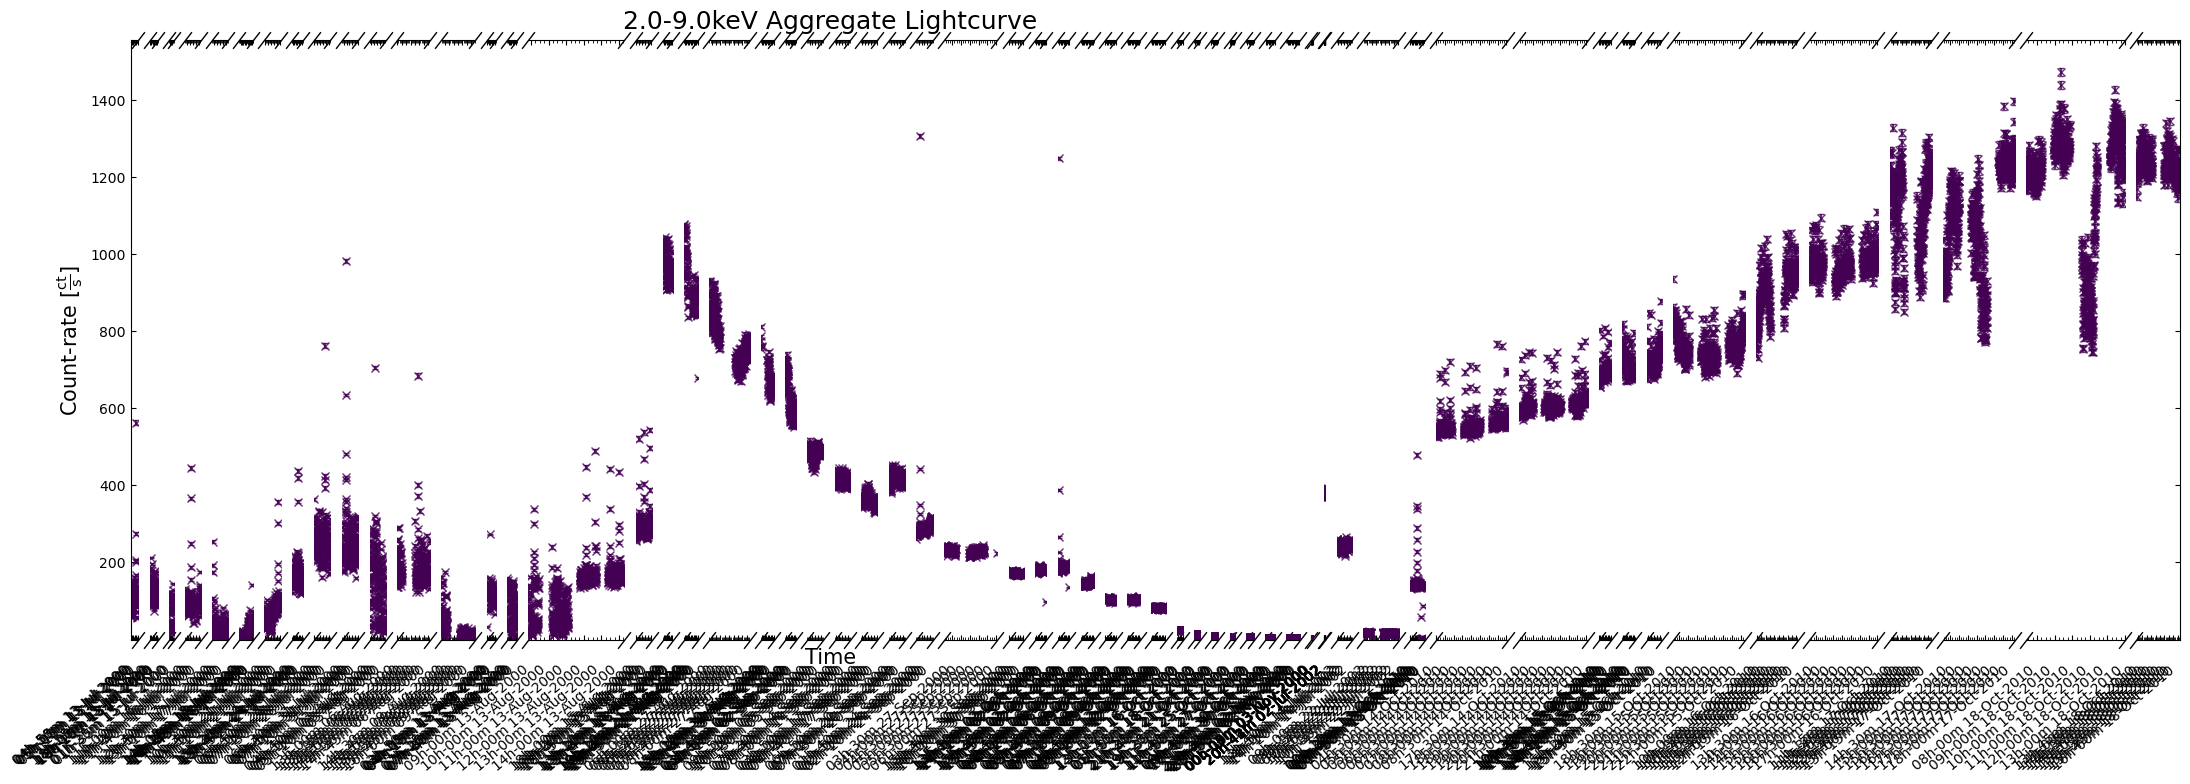

In [35]:
demo_agg_lc.view(show_legend=False)

To address the problems with the last figure, we could increase its size by passing a custom value to
the `figsize` argument (e.g. (30, 6)), or you could specify a particular time window to focus on:

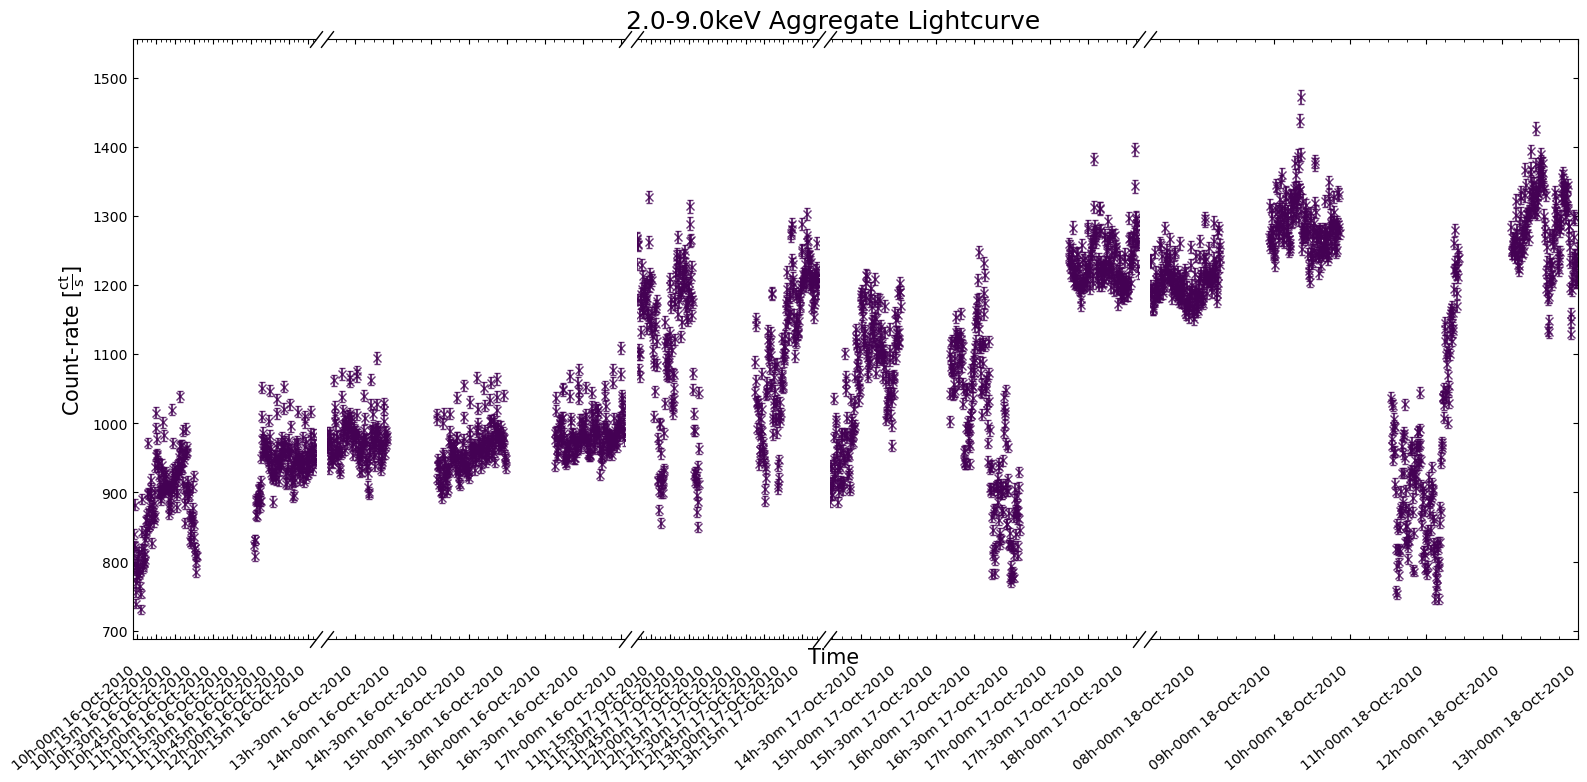

In [36]:
demo_agg_lc.view(
    interval_start=demo_agg_wind_start,
    interval_end=demo_agg_wind_stop,
    show_legend=False,
)

## 4. Generating new RXTE-PCA light curves

The time bin size of archived RXTE light curves is relatively coarse, particularly compared to the time resolution
that the PCA and HEXTE instruments can achieve. Given the type of object we are investigating, we might reasonably
expect that significant emission variations might be happening at smaller time scales than our time bin size.

Our inspiration for this demonstration, the work by [M. Linares et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012ApJ...748...82L/abstract),
generated RXTE-PCA light curves with different time bin sizes (2-second and 1-second bins) to search for different features.

Also, while light curves generated within several different energy bands are included in the RXTE archive, many
science cases will require that light curves be generated in very specific energy bands.

The archived light curves have gotten our exploration of T5X2's variable X-ray emission off to an excellent start, but
clearly we also need to be able to generate new versions that are tailored to our specific requirements.

This section of the notebook will go through the steps required to make RXTE-PCA light curves from scratch, focusing
on the two requirements mentioned above; smaller time bins, and control over light curve energy bands.

### Downloading specific files for our RXTE observations

Unfortunately, our first step is to spend even more time downloading data from the RXTE archive, as we previously
targeted only the archived light curve files. Making new light curves requires all the original data and many spacecraft
files.

The RXTE archive does not contain equivalents of the pre-cleaned event files found in many other HEASARC-hosted
high-energy telescope archives, which is why we will have to perform the calibration and reduction processes from scratch.

We could use the Astroquery `Heasarc.download_data()` object to download whole directories for all observations, just as
we demonstrated in the first part of Section 2, e.g.:

```
Heasarc.download_data(data_links, host="aws", location=ROOT_DATA_DIR)
```

However, to save some downloading time and storage space, we will take a slightly more complex approach
and download only the files we're going to need to reprocess the observations and generate new light curves.

We defined a list of files and directories that we ***do not need*** to download (`DOWN_EXCLUDE`) in the
'Global Setup: Constants' section near the top of the notebook, and we will use it in combination with
the `s3fs` Python module to list and filter the files in each observation's directory.

Then we will use `s3fs` to download just those files that we need:

In [37]:
for dl in data_links:
    cur_uri = dl["aws"]
    all_cont = np.array(
        s3.ls(
            cur_uri,
        )
    )
    down_mask = np.all(np.char.find(all_cont, DOWN_EXCLUDE[..., None]).T == -1, axis=1)
    down_cont = all_cont[down_mask].tolist()

    infer_oi = os.path.dirname(cur_uri).split("/")[-1]

    cur_out = os.path.join(ROOT_DATA_DIR, infer_oi)
    os.makedirs(cur_out, exist_ok=True)

    for cur_down_cont in down_cont:
        s3.get(cur_down_cont, cur_out, recursive=True, on_error="ignore")

```{note}
We note that it is generally recommended to reprocess high-energy event lists taken
from HEASARC mission archives from scratch, as it means that the latest calibration and filtering
procedures can be applied.
```

### Running the RXTE-PCA preparation pipeline

A convenient pipeline to prepare RXTE-PCA data for use is included in the HEASoft
package - `pcaprepobsid`. It will take us from raw RXTE-PCA data to the science-ready
data and filter files required to generate light curves in a later step - the PCA team
recommended the default configuration of the pipeline for general scientific use.

Now we have to talk about the slightly unusual nature of RXTE-PCA observations; the
PCA proportional counter units could be simultaneously read out in various
'data modes'. That meant that some limitations of the detectors and electronics could
be mitigated by using data from the different modes in different parts of your
analysis.

At least 10 different data modes could be requested by the observer, but the
'Standard-1' and 'Standard-2' modes were active for every observation.

The RXTE-PCA instrument had very high temporal and moderate spectral
resolutions, but both could not be true at the same time. The 'Standard-1' and
'Standard-2' modes 'binned' the readout from the detectors in two different ways:
- **Standard 1** - accumulated the combined readout from all detector channels, with a time resolution of 0.125 seconds.
- **Standard 2** - accumulated the 256 detector channels binned into 129 'Standard 2' channels, with a time resolution of 16 seconds.

```{note}
The Standard-2 data mode is the most commonly used and supported.
```

We are using the HEASoftPy interface to the `pcaprepobsid` task, but wrap it in
another function (defined in the 'Global Setup' section) that makes it easier for us
to run the processing of different observation's PCA data in parallel.

As the initial processing of raw data is the step in any analysis most likely
to error, we have made sure that the wrapper function returns information on whether
the processing failed, the logs, and the relevant ObsID. That makes
it easy for us to identify problem ObsIDs.

Now we run the pipeline for all of our selected RXTE observations:

In [38]:
with mp.Pool(NUM_CORES) as p:
    arg_combs = [[oi, os.path.join(OUT_PATH, oi), rel_coord] for oi in rel_obsids]
    pipe_result = p.starmap(process_rxte_pca, arg_combs)

pca_pipe_problem_ois = [
    all_out[0]
    for all_out in pipe_result
    if not all_out[2]
    or "Task pcaprepobsid 1.4 terminating with status -1" in str(all_out[1])
]
rel_obsids = [oi for oi in rel_obsids if oi not in pca_pipe_problem_ois]

pca_pipe_problem_ois

/opt/envs/heasoft/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2038) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


['50054-06-08-00', '50054-06-08-01', '50054-06-08-03', '50054-06-08-04']

### Setting up RXTE-PCA good time interval (GTI) files

The RXTE-PCA data for our observations of T5X2 are now (sort of) ready for use!

Though the observation data files have been prepared, we do still need to define
'good time interval' (GTI) files for each observation. These will combine the filter
file produced by `pcaprepobsid`, which is determined by various spacecraft orbit and
electronics housekeeping considerations, with another user-defined filtering expression.

The user-defined filter is highly customizable, but we will use the expression
recommended (see the note below for the source of this recommendation) to
apply 'basic' screening to RXTE-PCA observations of a bright target:

In [39]:
# Recommended filtering expression from RXTE cookbook pages
filt_expr = "(ELV > 4) .AND. (OFFSET < 0.1) .AND. (NUM_PCU_ON > 0 .AND. NUM_PCU_ON < 6)"

Breaking down the terms of the filter expression:
- **ELV > 4** - Ensures that the target is above the Earth's horizon. More conservative limits (e.g. > 10) will make sure that 'bright earth' is fully screened out, but this value is sufficient for many cases.
- **OFFSET < 0.1** - Makes sure that PCA is pointed at the target to within 0.1 degrees.
- **NUM_PCU_ON > 0 .AND. NUM_PCU_ON < 6** - Ensures that at least one of the five proportional counter units is active.

```{seealso}
An [in-depth discussion](https://heasarc.gsfc.nasa.gov/docs/xte/recipes2/Screening.html?QuickLinksMenu=/vo/) of how
to screen/filter RXTE-PCA data is available on the HEASARC website.
```

Now that we've settled on the filtering expression, the `maketime` HEASoft task can
be used to make the final GTI files for each observation. Another wrapper function to
the HEASoftPy `maketime` interface is declared, and we again execute the task in parallel:

In [40]:
with mp.Pool(NUM_CORES) as p:
    arg_combs = [[oi, os.path.join(OUT_PATH, oi), filt_expr] for oi in rel_obsids]
    gti_result = p.starmap(gen_pca_gti, arg_combs)

### New light curves within custom energy bounds

Recall that we want to generate two categories of custom light curves; those within
custom energy bands, and those with time resolution better than 16 seconds.

We'll tackle the custom energy band light curves first, as they use the more common
data mode, 'Standard-2'. The generation of these light curves will be
straightforward, as HEASoft includes a task called `pcaextlc2` for exactly this
purpose.

As previously mentioned, the RXTE-PCA instrument is made up of five separate
proportional counter units (PCUs). The state and reliability of those PCUs varied
significantly over the lifetime of the mission, so we do not necessarily use want to
use data from all five.

PCU 2 was considered the most reliable, and so we are going to use that for our newly
generated light curves.

In [41]:
chos_pcu_id = "2"

```{note}
The default behaviour of PCA light curve generation functions in HEASoft is to use all
available PCUs, in which case a combined light curve is produced. We have set up
our wrapper functions for the light curve generation tasks so that a single PCU
or a list of PCUs can be passed.
```

The slight sticking point is that `pcaextlc2` takes arguments of upper and
lower **absolute channel** limits to specify which band the output light curve should be
generated within. Our particular science case will inform us which **energy** bands
we should look at, but we have to convert them to channels ourselves.

```{caution}
It is important to make a distinction between RXTE-PCA **'Standard-2'** channels (which
have values between 0 and 128) and PCA's **absolute** channels (which have values between
0 and 255). Standard-2 is a _binned_ data mode, and its channels represent combinations
of absolute channels.
```

We need to convert our energy bands (whatever we decide they will be) to the
equivalent **absolute** channels. HEASARC [provides a table](https://heasarc.gsfc.nasa.gov/docs/xte/e-c_table.html) that describes the
mapping of absolute channels to 'Standard-2' channels and energies at different
epochs in the life of the telescope.

You could quite easily use this to convert from your target energy band to the
absolute channel limits, but when dealing with many archival observations from
different epochs, it is more convenient to implement a more automated solution.

#### Building RXTE-PCA response files

That automated method of converting from energy to channel involves:
1. Generating new RXTE-PCA response files for each observation
2. Using the "EBOUNDS" table of responses to move from energy to 'Standard-2' channel
3. Finally, using the known binning of 'Standard-2' channels to arrive at the absolute channel limits.

We note that as some, but not all, 'Standard-2' channels correspond to a range
of absolute channels, the mean value of the absolute channel range is used, and rounded
down to the nearest integer for the lower limit, and rounded up to the nearest integer
for the upper limit.

Rather than using the HEASoft tool specifically for generating RXTE-PCA RMFs, we
cheat a little and use the HEASoft tool designed to produce spectra (and supporting
files) from RXTE-PCA data; `pcaextspect2`.

The advantage of this is that `pcaextspect2` will automatically handle the combination
of responses from different PCUs, which would not be necessary for our use of PCU 2, but
makes it easier to use multiple PCUs if you choose.

As with the other HEASoft tasks, we write a wrapper function for the HEASoftPy
interface in order to run the task in parallel:

In [42]:
with mp.Pool(NUM_CORES) as p:
    arg_combs = [[oi, os.path.join(OUT_PATH, oi), chos_pcu_id] for oi in rel_obsids]
    rsp_result = p.starmap(gen_pca_s2_spec_resp, arg_combs)

```{note}
The response files produced by `pcaextspect2` are a combination of the ARF and RMF
products commonly seen in high energy astrophysics data.
```

To make the next step easier, we set up a template for the path to the response files
we just generated:

In [43]:
rsp_path_temp = os.path.join(OUT_PATH, "{oi}", "rxte-pca-pcu{sp}-{oi}.rsp")

#### Generating the light curves

Now that the response files have been generated, we can create our new light curves!

The first step is to decide on the lower and upper limits of the energy band(s) we want
the light curve(s) to be drawn from. We also define the time bin size to use, remembering
that the 'Standard-2' data mode required for applying energy bounds has
a minimum time resolution of 16 seconds.

We choose to build light curves in three custom energy bands:
- 2-10 keV
- 10-30 keV
- 2-60 keV

These selections are fairly arbitrary and aren't physically justified, but yours
should be informed by your science case. If you are using this code as a template
for your own analysis, you could add more energy bands to the `new_lc_en_bnds` list,
and they would be generated as well.

We choose a time bin size of 16 seconds, as this is a bright source and we wish
for the best possible temporal resolution.

In [44]:
new_lc_en_bnds = [
    Quantity([2, 10], "keV"),
    Quantity([10, 30], "keV"),
    Quantity([2, 60], "keV"),
]

en_time_bin_size = Quantity(16, "s")

Now we can run the `pcaextlc2` task to generate the light curves. We note that the
wrapper function we create for the HEASoftPy interface to `pcaextlc2` includes
extra processing steps that use the supplied lower and upper energy limits and
response file to determine the absolute channel limits. Please examine the
wrapper function defined in the 'Global Setup' section for more details.

In [45]:
form_sel_pcu = pca_pcu_check(chos_pcu_id)

with mp.Pool(NUM_CORES) as p:
    arg_combs = [
        [
            oi,
            os.path.join(OUT_PATH, oi),
            *cur_bnds,
            rsp_path_temp.format(oi=oi, sp=form_sel_pcu),
            en_time_bin_size,
            chos_pcu_id,
        ]
        for oi in rel_obsids
        for cur_bnds in new_lc_en_bnds
    ]
    lc_en_result = p.starmap(gen_pca_s2_light_curve, arg_combs)

Finally, we set up a template for the path to the light curves we just generated:

In [46]:
lc_path_temp = os.path.join(
    OUT_PATH, "{oi}", "rxte-pca-pcu{sp}-{oi}-en{lo}_{hi}keV-tb{tb}s-lightcurve.fits"
)

#### Loading the light curves into Python

Our shiny new custom-energy-band light curves can be loaded into convenient XGA LightCurve
objects, just as the archived light curves were - they will once again provide a
convenient interface to the data, and some nice visualization capabilities.

As we set up the energy bands in which to generate new light curves as a list of
Astropy quantities (which you may add to or remove from for your own purposes), and we
know the format of the output file names (as we set that up), we can dynamically
load in those light curves.

Iterating through the energy bounds, and the relevant ObsIDs, every new light curve
file gets its own LightCurve object, and is then appended to a list in a dictionary
with energy bands as keys.

From there, one aggregate light curve per energy band is set up and also stored in a
dictionary for easy (and dynamic) access:

In [47]:
gen_en_bnd_lcs = {}

for cur_bnd in new_lc_en_bnds:
    cur_bnd_key = "{0}-{1}keV".format(*cur_bnd.value)
    gen_en_bnd_lcs.setdefault(cur_bnd_key, [])

    for oi in rel_obsids:
        cur_lc_path = lc_path_temp.format(
            oi=oi,
            sp=form_sel_pcu,
            tb=en_time_bin_size.value,
            lo=cur_bnd[0].value,
            hi=cur_bnd[1].value,
        )

        cur_lc = LightCurve(
            cur_lc_path,
            oi,
            "PCA",
            "",
            "",
            "",
            rel_coord_quan,
            Quantity(0, "arcmin"),
            RXTE_AP_SIZES["PCA"],
            *cur_bnd,
            en_time_bin_size,
            telescope="RXTE",
        )

        gen_en_bnd_lcs[cur_bnd_key].append(cur_lc)

# Set up the aggregate light curves
agg_gen_en_bnd_lcs = {
    cur_bnd_key: AggregateLightCurve(cur_bnd_lcs)
    for cur_bnd_key, cur_bnd_lcs in gen_en_bnd_lcs.items()
}

# Show the structure of the agg_gen_en_bnd_lcs dictionary
agg_gen_en_bnd_lcs

{'2.0-10.0keV': <xga.products.lightcurve.AggregateLightCurve at 0x7fecea1b7980>,
 '10.0-30.0keV': <xga.products.lightcurve.AggregateLightCurve at 0x7fee4d9b1070>,
 '2.0-60.0keV': <xga.products.lightcurve.AggregateLightCurve at 0x7fee4da0b3b0>}

#### Visualizing new custom-energy-band light curves

The first thing to do is to take a look at one of our new light curves to make sure
that (on the surface at least) everything looks reasonably sensible.

You should really examine the whole aggregation of new light curves in a particular
energy band, but for demonstrative purposes we'll look at a two-week time window:

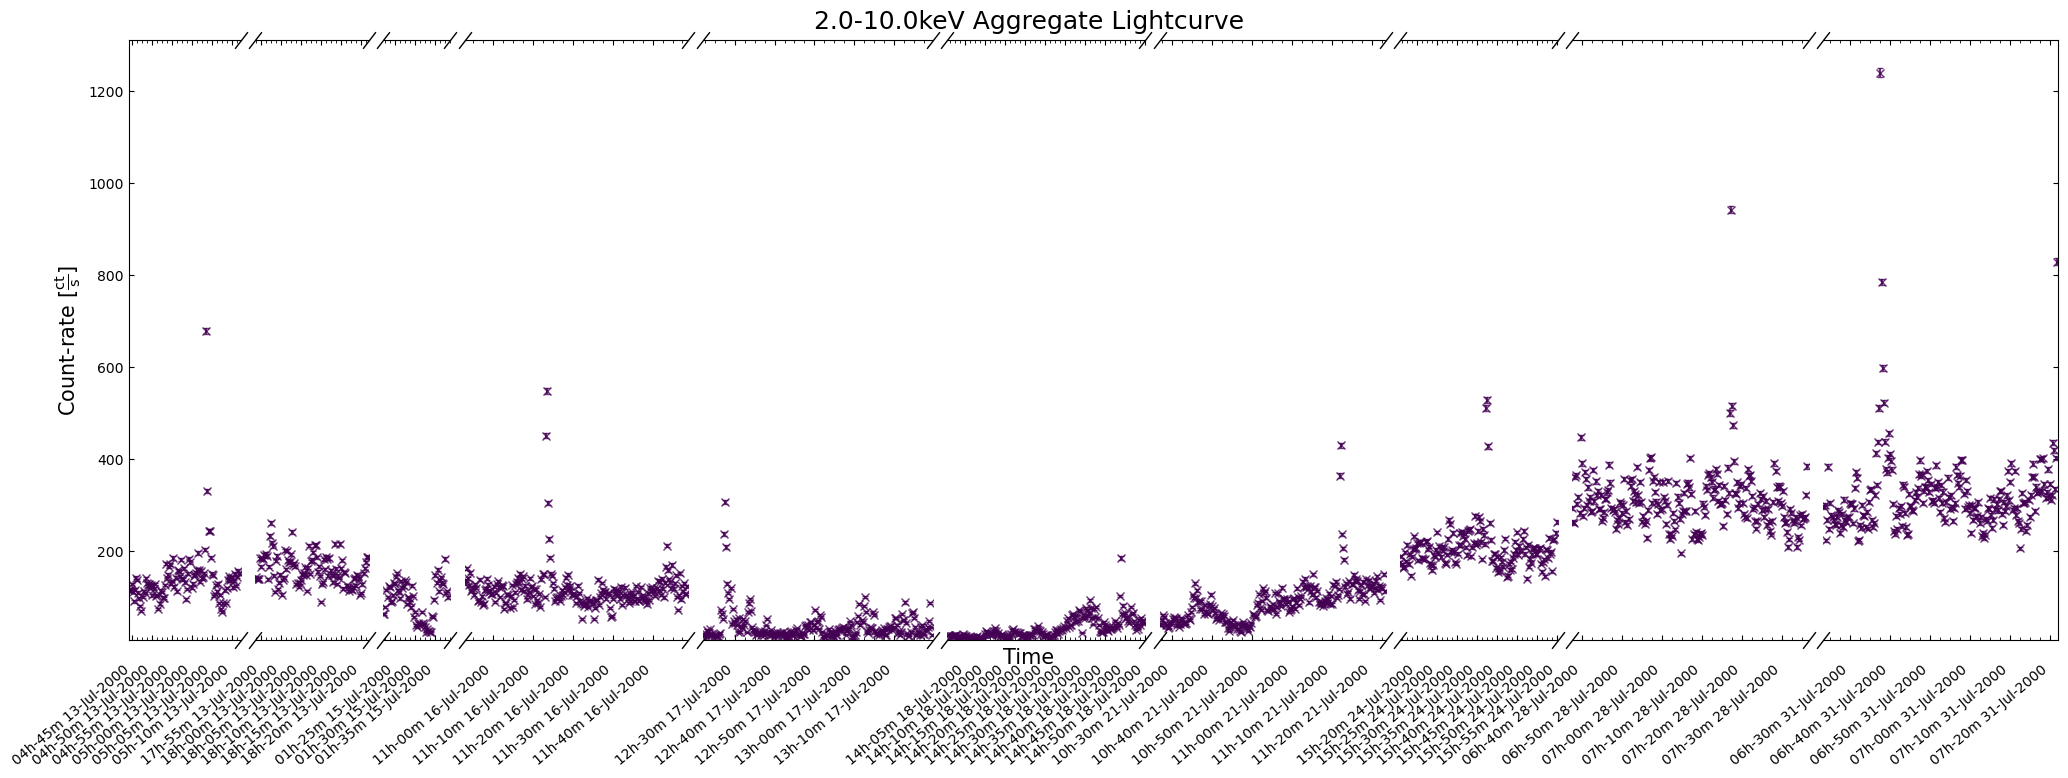

In [48]:
agg_gen_en_bnd_lcs["2.0-10.0keV"].view(
    show_legend=False,
    figsize=(18, 6),
    interval_start=Time("2000-07-13 05:00:00"),
    interval_end=Time("2000-08-03"),
)

#### Calculating and examining hardness ratio curves

Being able to generate light curves within energy bands of our choice will be a
useful tool for many science cases; for instance, sometimes you wish to target
particular emission mechanisms that produce X-ray photons of a certain energy.

Sometimes you take a broader view and simply want to know if the variation in
emission is distinct between the 'soft' X-ray band to the 'hard' X-ray band (exactly what
defines 'hard' and 'soft' will vary depending on your specialization, the telescope
you're using, and sometimes just how you feel on a particular day).

In either case it is often useful to visualize a 'hardness curve' which shows how the
'hardness ratio' of two energy bands changes with time. There are multiple definitions
of the hardness ratio, but for our purposes we'll use:

$$\rm{HR}_{{H:S}} = \frac{F_{H} - F_{S}}{F_{H} + F_{S}}.$$

Where $\rm{HR}_{{H:S}}$ is the hard-to-soft band ratio, $F_{H}$ is the flux in the hard band,
and $F_{S}$ is the flux in the soft band.

Hardness curves can be considered as a short-cut to the sort of information extracted from
time-resolved spectroscopy (which is outside the scope of this tutorial).

```{seealso}
Our calculation of hardness ratio is fairly simplistic - there are better approaches
that take into account the often-Poissian nature of X-ray light curve data points, and
calculate uncertainties on the ratio. See the
[Chandra Source Catalog hardness ratio](https://cxc.cfa.harvard.edu/csc/columns/spectral_properties.html) page for an example.

```

We will choose a single observation to visualize the hardness ratio curve for, just for
ease of viewing; there is no reason you could not use the same approach for all
observations.

Three energy-bands were chosen when we generated the new light curves earlier in this
section, and we will choose the 2.0–10 keV as the soft band, and the 10.0–30 keV as
the hard band:

In [49]:
hard_rat_ch_id = 9

lo_en_demo_lc = agg_gen_en_bnd_lcs["2.0-10.0keV"].get_lightcurves(hard_rat_ch_id)
hi_en_demo_lc = agg_gen_en_bnd_lcs["10.0-30.0keV"].get_lightcurves(hard_rat_ch_id)

hard_rat = (hi_en_demo_lc.count_rate - lo_en_demo_lc.count_rate) / (
    hi_en_demo_lc.count_rate + lo_en_demo_lc.count_rate
)

The figure we produce plots the two light curves on the same axis, and then the calculated hardness curve
on a second axis below. As such, we can both see the original behaviors evident in the light curves, and how
the hardness ratio changes for those behaviors.

We find that the hardness ratio is effectively constant for much of the chosen
observation, and that the approximately constant value indicates that more
emission is detected in the soft band than the hard.

Interestingly, when we see a very large increase in emission from a burst, the hardness
ratio drops significantly, becoming even more negative. Thinking back to the hardness
ratio definition, it is clear that these large bursts emit more photons in the
soft-band (2–10 keV in this case) than the hard-band (10–30 keV).

Interpreting this sort of behavior is heavily dependent on your science case and the
astrophysics involved in whatever object you are studying. However, our initial hypothesis
here might be that the large bursts originate from a different mechanism than the
smaller variations in emission we see elsewhere in the light curves.

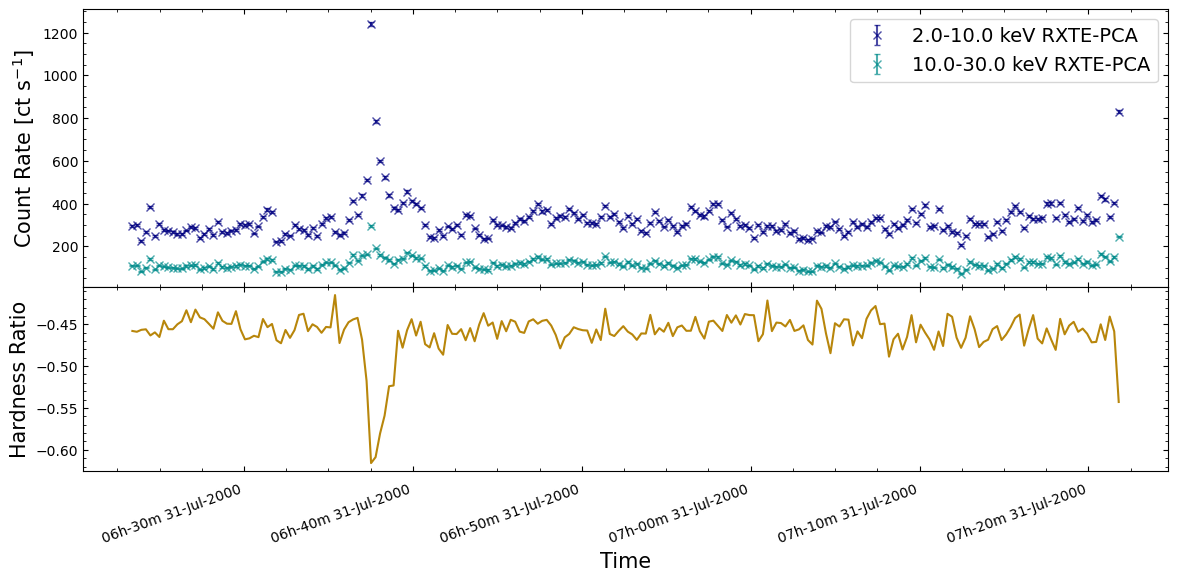

In [50]:
# Currently no convenient XGA method to define HardnessCurves and plot them, so
#  we'll do it manually
# Set up a two-panel figure, with the top panel taller than the bottom. Also
#  include sharex=col to join the x-axis (time) of the two panels
fig, ax_arr = plt.subplots(nrows=2, figsize=(14, 6), height_ratios=[3, 2], sharex="col")
# Shrink the vertical gap between the panels to zero
fig.subplots_adjust(hspace=0)

# Set up ticks for both axes
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in", top=True, right=True)

# Plot the light curves on the same axis (top panel)
ax_arr[0].errorbar(
    lo_en_demo_lc.datetime,
    lo_en_demo_lc.count_rate,
    yerr=lo_en_demo_lc.count_rate_err,
    fmt="x",
    color="navy",
    capsize=2,
    alpha=0.7,
    label=r"{0}-{1} keV RXTE-PCA".format(
        lo_en_demo_lc.energy_bounds[0].value, lo_en_demo_lc.energy_bounds[1].value
    ),
)
ax_arr[0].errorbar(
    hi_en_demo_lc.datetime,
    hi_en_demo_lc.count_rate,
    yerr=hi_en_demo_lc.count_rate_err,
    fmt="x",
    color="darkcyan",
    capsize=2,
    alpha=0.7,
    label=r"{0}-{1} keV RXTE-PCA".format(
        hi_en_demo_lc.energy_bounds[0].value, hi_en_demo_lc.energy_bounds[1].value
    ),
)
# Add a legend to distinguish between the two light curves
ax_arr[0].legend(fontsize=14)
# Set up the y-axis label
ax_arr[0].set_ylabel(r"Count Rate [ct s$^{-1}$]", fontsize=15)

# Plot the previously-calculated hardness curve on the bottom panel
ax_arr[1].plot(lo_en_demo_lc.datetime, hard_rat, color="darkgoldenrod")
# Label the y-axis
ax_arr[1].set_ylabel(r"Hardness Ratio", fontsize=15)
# Label the x-axis. Note that we didn't do this for the light curve axis
#  because the vertical gap between the two panels is zero, and they
#  share the same x-axis anyway
ax_arr[1].set_xlabel("Time", fontsize=15)

# Format the datetimes on the x-axis in an easier-to-read way
ax_arr[1].xaxis.set_major_formatter(mdates.DateFormatter("%Hh-%Mm %d-%b-%Y"))
for label in ax.get_xticklabels(which="major"):
    label.set(
        y=label.get_position()[1] - 0.03, rotation=20, horizontalalignment="right"
    )

plt.show()

### New light curves with high temporal resolution

Addressing our other reason for generating new light curves, we can now use the
'Standard-1' data mode to achieve a much finer temporal resolution than the 'Standard-2' mode.

We select a time bin size of 2 seconds to match the temporal resolution of the
RXTE-PCA light curves that [M. Linares et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012ApJ...748...82L/abstract)
used to identify T5X2 bursts:

In [51]:
new_lc_time_bin_sizes = Quantity([1, 2], "s")

This is still considerably oversampling the potential time resolution for 'Standard-1'
data, as it is binned into 0.125 second chunks.

#### Generating new light curves

Unlike when we made new light curves within a custom energy band, we don't need to
worry about converting from energy to channels as, unfortunately, 'Standard-1' data
does not contain any spectral information.

```{warning}
Though 'Standard-1' data contains no spectral information (as it consists of the
combined readout from all detector channels) the `pcaextlc1` HEASoft task does
take minimum and maximum channel arguments - **do not use them**.
```

Here we wrap and run the `pcaextlc1` task in parallel, just as we did `pcaextlc2` in the last section:

In [52]:
form_sel_pcu = pca_pcu_check(chos_pcu_id)

with mp.Pool(NUM_CORES) as p:
    arg_combs = [
        [
            oi,
            os.path.join(OUT_PATH, oi),
            cur_tsz,
            chos_pcu_id,
        ]
        for oi in rel_obsids
        for cur_tsz in new_lc_time_bin_sizes
    ]
    lc_result = p.starmap(gen_pca_s1_light_curve, arg_combs)

/opt/envs/heasoft/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2038) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Finally, we set up a template for the path to the light curves we just generated:

In [53]:
lc_hi_res_path_temp = os.path.join(
    OUT_PATH, "{oi}", "rxte-pca-pcu{sp}-{oi}-enALL-tb{tb}s-lightcurve.fits"
)

#### Loading the light curves into Python

Just as we did for the archived light curves and the newly generated energy-bound
light curves, we will load the new files into XGA LightCurve objects, and from there
into an AggregateLightCurve per time-bin-size:

In [54]:
gen_hi_time_res_lcs = {}

for cur_tsz in new_lc_time_bin_sizes:
    cur_tsz_key = cur_tsz.to_string().replace(" ", "")
    gen_hi_time_res_lcs.setdefault(cur_tsz_key, [])

    for oi in rel_obsids:
        cur_lc_path = lc_hi_res_path_temp.format(
            oi=oi, sp=form_sel_pcu, tb=cur_tsz.value
        )

        cur_lc = LightCurve(
            cur_lc_path,
            oi,
            "PCA",
            "",
            "",
            "",
            rel_coord_quan,
            Quantity(0, "arcmin"),
            RXTE_AP_SIZES["PCA"],
            Quantity(2, "keV"),
            Quantity(60, "keV"),
            cur_tsz,
            telescope="RXTE",
        )

        gen_hi_time_res_lcs[cur_tsz_key].append(cur_lc)

# Set up the aggregate light curves
agg_gen_hi_time_res_lcs = {
    cur_tsz_key: AggregateLightCurve(cur_tsz_lcs)
    for cur_tsz_key, cur_tsz_lcs in gen_hi_time_res_lcs.items()
}

# Show the structure of the agg_gen_hi_time_res_lcs dictionary
agg_gen_hi_time_res_lcs

{'1.0s': <xga.products.lightcurve.AggregateLightCurve at 0x7fee4cd12300>,
 '2.0s': <xga.products.lightcurve.AggregateLightCurve at 0x7fee4d25ae40>}

#### Visualizing new higher time-resolution light curves

We can now visually examine the new higher-temporal-resolution light curves. It is
always good practice to visually examine your data, as it can help you spot any
potential problems, as well as any interesting features.

There are new light curves with both one-second and two-second time bins, but here we
will select the highest-resolution option to examine.

Rather than looking at the whole aggregate light curve, we choose a small date range
to increase the interpretability of the output figure:

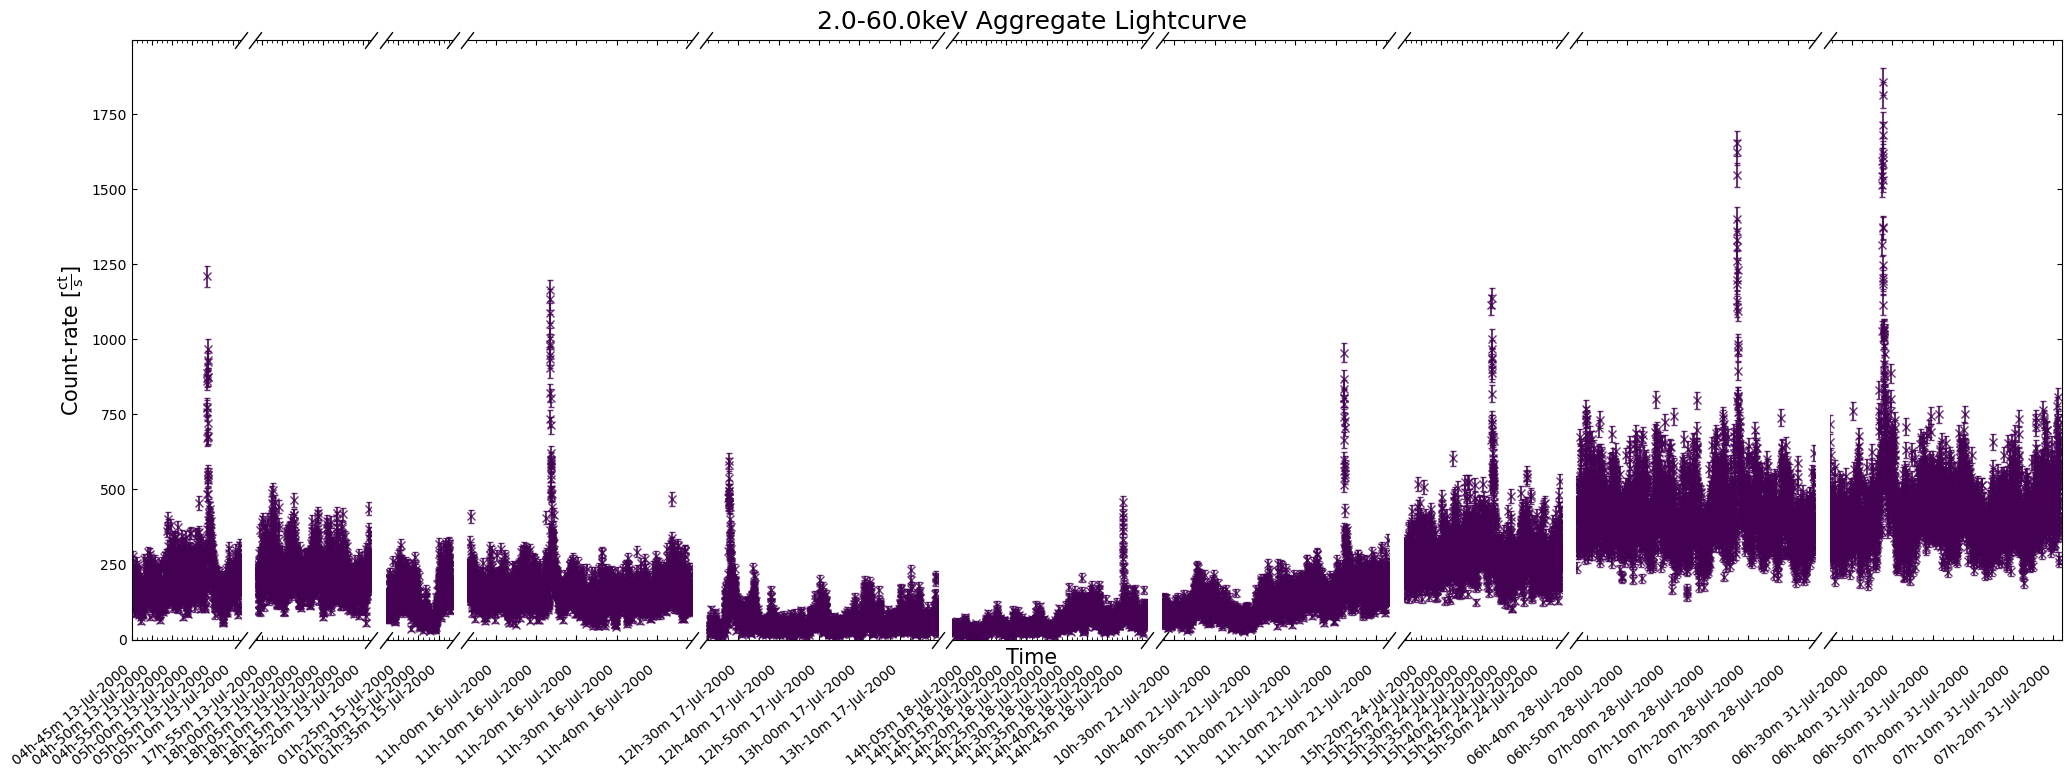

In [55]:
agg_gen_hi_time_res_lcs["1.0s"].view(
    show_legend=False,
    figsize=(18, 6),
    interval_start=Time("2000-07-13 05:00:00"),
    interval_end=Time("2000-08-03"),
)

To give a sense of how the finer temporal bins might affect our interpretation of
our source's (T5X2) time-varying behavior, we are going to plot a single
observation's light curve generated with one, two, and sixteen second time bins.

The sixteen-second time bin light curve is in the same energy band as the two
fine-temporal-resolution light curves (2–60 keV), and was generated in the
"New light curves within custom energy bounds" section of this notebook.

We access the relevant aggregate light curves and extract a single light curve from
each - the selected light curves are all from the same time bin (thus observation), as
we wish to compare like-to-like:

In [56]:
tbin_comp_ch_id = 9

onesec_demo_lc = agg_gen_hi_time_res_lcs["1.0s"].get_lightcurves(tbin_comp_ch_id)
twosec_demo_lc = agg_gen_hi_time_res_lcs["2.0s"].get_lightcurves(tbin_comp_ch_id)

sixteensec_demo_lc = agg_gen_en_bnd_lcs["2.0-60.0keV"].get_lightcurves(tbin_comp_ch_id)

Plotting the light curves on the same axis is an excellent demonstration of
**why** we bothered to make new light curves with finer time binning in the first
place.

The default sixteen-second binning clearly obfuscates many of the smaller, shorter
timescale, variations in T5X2's 2–60 keV X-ray emission. Larger features are still
clear, though broadened by the coarser time bins, but finer time bins reveal a lot
of interesting features:

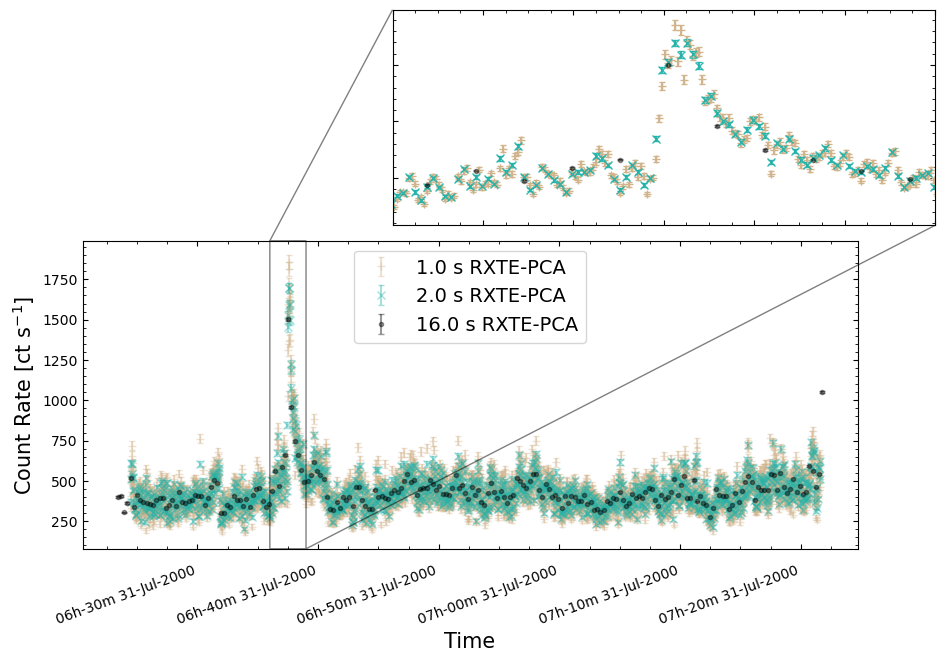

In [57]:
# There is currently no XGA-native way to plot curves with different time bins
#  on the same axis, so we will do it ourselves

# Sets up a figure
fig = plt.figure(figsize=(10, 4))
ax = plt.gca()

# Formats the number and appearance of the y and x axis ticks
ax.minorticks_on()
ax.tick_params(which="both", direction="in", top=True, right=True)

# Plot the three light curves, including count-rate uncertainties
plt.errorbar(
    onesec_demo_lc.datetime,
    onesec_demo_lc.count_rate,
    yerr=onesec_demo_lc.count_rate_err,
    fmt="+",
    color="tan",
    capsize=2,
    alpha=0.4,
    label=r"{} s RXTE-PCA".format(onesec_demo_lc.time_bin_size.value),
)
plt.errorbar(
    twosec_demo_lc.datetime,
    twosec_demo_lc.count_rate,
    yerr=twosec_demo_lc.count_rate_err,
    fmt="x",
    color="lightseagreen",
    capsize=2,
    alpha=0.4,
    label=r"{} s RXTE-PCA".format(twosec_demo_lc.time_bin_size.value),
)
plt.errorbar(
    sixteensec_demo_lc.datetime,
    sixteensec_demo_lc.count_rate,
    yerr=sixteensec_demo_lc.count_rate_err,
    fmt=".",
    color="black",
    capsize=2,
    alpha=0.4,
    label=r"{} s RXTE-PCA".format(sixteensec_demo_lc.time_bin_size.value),
)

# We added labels to each plot, so will include a legend to help identify the
#  different curves
plt.legend(fontsize=14, loc="upper center")
# Label the axes
plt.ylabel(r"Count Rate [ct s$^{-1}$]", fontsize=15)
plt.xlabel("Time", fontsize=15)

# The x-axis data were in the form of datetimes, and we can use a matplotlib
#  formatted to ensure that the tick labels are displayed correctly
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Hh-%Mm %d-%b-%Y"))
# We also rotate the tick labels to make them easier to read
for label in ax.get_xticklabels(which="major"):
    label.set(
        y=label.get_position()[1] - 0.03, rotation=20, horizontalalignment="right"
    )

# The overall view of one observation's light curve is still a little too broad
#  to really see the detailed differences that time bin size makes, so we will
#  also include an inset zoom.
# These are the zoom start and end times
zoom_start = Time("2000-07-31 06:36:00").datetime
zoom_end = Time("2000-07-31 06:39:00").datetime

# Add an inset axes that the zoomed view will be plotted in
#  The list of numbers as the first argument defines the position of the lower left
#  corner, and the size, of the axis
axins = ax.inset_axes(
    [0.4, 1.05, 0.7, 0.7],
    xlim=(zoom_start, zoom_end),
    ylim=plt.ylim(),
    xticklabels=[],
    yticklabels=[],
)
# Once again format the ticks
axins.minorticks_on()
axins.tick_params(which="both", direction="in", top=True, right=True)

# Have to plot the same information again on the new axis
axins.errorbar(
    onesec_demo_lc.datetime,
    onesec_demo_lc.count_rate,
    yerr=onesec_demo_lc.count_rate_err,
    fmt="+",
    color="tan",
    capsize=2,
    alpha=1,
    label=r"{} s RXTE-PCA".format(onesec_demo_lc.time_bin_size.value),
)
axins.errorbar(
    twosec_demo_lc.datetime,
    twosec_demo_lc.count_rate,
    yerr=twosec_demo_lc.count_rate_err,
    fmt="x",
    color="lightseagreen",
    capsize=2,
    alpha=0.9,
    label=r"{} s RXTE-PCA".format(twosec_demo_lc.time_bin_size.value),
)
axins.errorbar(
    sixteensec_demo_lc.datetime,
    sixteensec_demo_lc.count_rate,
    yerr=sixteensec_demo_lc.count_rate_err,
    fmt=".",
    color="black",
    capsize=2,
    alpha=0.4,
    label=r"{} s RXTE-PCA".format(sixteensec_demo_lc.time_bin_size.value),
)
# We don't include axis labels on the inset zoom, as we found them to be
#  small, visually confusing, and ultimately not necessary due to the presence
#  of the main plot

# Adds nice boxes and lines between the zoomed region on the main axis and
#  the new inset axis
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()

## 5. Experimenting with an automated method to identify bursts

For the final step of this demonstration, we will experiment with automated ways to
identify when T5X2 bursts occur. The work by [M. Linares et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012ApJ...748...82L/abstract)
that inspired this tutorial identified bursts by manual inspection of light curves with
two-second time resolution.

Manual inspection by experts is often the most reliable way to identify features like
bursts, even though it is _possible_ it may introduce unquantifiable human error and
biases.

Such manual inspection is unfortunately very time-consuming, and factors such as
decision fatigue (see [M. Maier et al. 2024](https://www.tandfonline.com/doi/full/10.1080/17437199.2025.2513916), for a review of decision fatigue
in medical decision-making) can cause a variation in the inspector's performance
over the course of the task.

As such, and because it is an interesting thing to do with the light curves we have
just generated, we will attempt the same task algorithmically.


We match the light curves used for burst identification by
[M. Linares et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012ApJ...748...82L/abstract),
choosing our new two-second time bin light curves to experiment with. An individual
light curve from that aggregated light curve is also selected for testing purposes:

In [58]:
burst_id_demo_agg_lc = agg_gen_hi_time_res_lcs["2.0s"]
burst_id_demo_lc = burst_id_demo_agg_lc.get_lightcurves(4)

### Wavelet transform peak finding

Continuous wavelet transform (CWT) peak finding is a relatively simple way to try and
find peaks in a time-varying signal, or indeed any one-dimensional data set.

The process involves convolving wavelets with the light curve and then identifying
data points that are above some threshold of signal-to-noise; by retrieving the time
information that corresponds to those peak data points, we can identify the times of
what we hope are bursts.

The idea behind the wavelet transform approach is that convolving a wavelet function
of a particular width will amplify features in the time series (light curve) that
are of similar widths and smooth out those features which are not.

It is possible, and often very beneficial, to convolve several different wavelet scales
with the same data to try and pull out features of different scales.

```{note}
Another important use of wavelet transforms in high-energy astrophysics is as a
mechanism for source detection in X-ray images! There different wavelet scales
help to identify both point and extended sources.
```

Peak finding using CWTs is conveniently already implemented in the commonly used
`scipy` package, and here we will demonstrate its use on our new RXTE-PCA light curves.

#### Testing on a single light curve

To validate how well this method appears to work on the time-varying emission from
T5X2, as observed with RXTE-PCA, we first run CWT peak finding on a single light curve.

Any peak detection algorithm will have configuration or parameters that are set
to control the behavior of the detection process.

The particular configuration you use will depend on several factors, including:

- Your science case; i.e., the features you're searching for.
- The nature of the data; is it high signal-to-noise? what is the light curve time resolution?
- The level of contamination from false positives (and false negatives) you're willing to tolerate.

You may also have to do some 'tuning' where you experiment with different
values of the configuration parameters to produce what seems to be the highest
quality results.

All that said, please don't take our choice of configuration as a recommendation for
how to use CWT peak finding in your own work!

We use the following configuration parameters:
- Wavelet widths of **2** and **5**; **four** and **ten** seconds respectively (for our 2-second-binned light curves)..
- A minimum signal-to-noise of **3** for a convolved data point to be considered a peak.

```{important}
The SciPy implementation of continuous wavelet transform peak-finding has more
configuration options than we have used here. Descriptions are available in the
[SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks_cwt.html).
```

Running the peak-finding algorithm is as simple as:

In [59]:
wt_lc_demo_bursts = find_peaks_cwt(burst_id_demo_lc.count_rate, [2, 5], min_snr=3)
wt_lc_demo_bursts

array([ 142,  144,  328,  457,  458,  607, 1154, 1193, 1423, 1424, 1477,
       1501, 1627, 1683])

```{tip}
SciPy's `find_peaks_cwt()` function returns indices of the array/list elements of
the input data that it defines as peaks. The peak indices can then be used to
extract the peak times from the light curve's `time` or `datetime` properties.
```

#### Visualizing peak times identified for the single light curve

Now we'll look at the single light curve we just tested CWT peak finding on, making
a small addition of a vertical line the height of the axis at every time identified
as a 'peak'.

The results are quite encouraging, with many peaks evident from manual inspection also
identified by CWT peak finding!

It isn't perfect, as some obvious peaks in the emission are not automatically
identified, and some bursts appear to have multiple peaks erroneously associated with them.

Regardless, this technique is clearly a possibly promising avenue for automated burst
detection and with some tuning of the wavelet scales and signal-to-noise threshold,
could be made much more reliable. We also note that CWT is a simple and relatively
fast process, which brings its own advantages when applying it at scale.

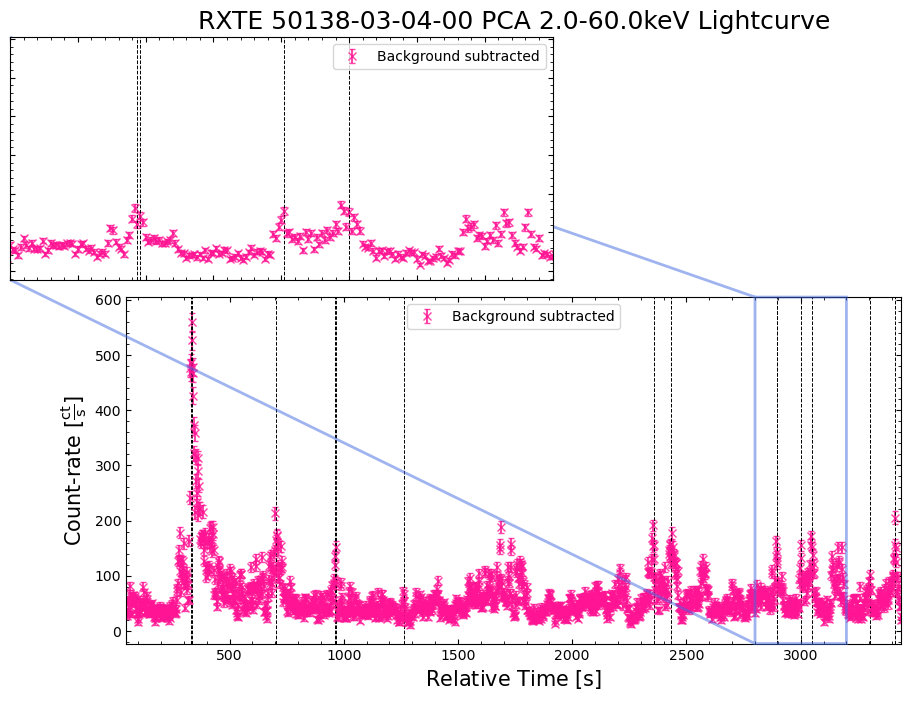

In [60]:
# Set up a figure, specifying the size
plt.figure(figsize=(10, 4.5))
# Fetch the axis that was created along with it, so it can be passed to get_view()
ax = plt.gca()

# This will populate the axis so that it looks like the light curve visualisations
#  we've already been looking at
ax = burst_id_demo_lc.get_view(ax, "s", colour="deeppink")

# Iterate through the possible peaks, and add them to our retrieved, populated, axes
for p_pos in wt_lc_demo_bursts:
    p_time = burst_id_demo_lc.time[p_pos] - burst_id_demo_lc.start_time
    plt.axvline(p_time.value, color="black", linestyle="dashed", linewidth=0.7)

# Setting the start and end times (in seconds relative to the beginning of
#  this light curve's observation) of the zoom-in region
demo_wt_lc_zoom_start = 2800
demo_wt_lc_zoom_end = 3200

# Adding an inset axes, in which we will have a zoomed view of a particular
#  part of the light curve.
# The first argument of a list of numbers defines the position of the lower left
#  corner of the inset axes, and its size
axins = ax.inset_axes(
    [-0.15, 1.05, 0.7, 0.7], ylim=plt.ylim(), xticklabels=[], yticklabels=[]
)
# Configure the ticks on the new axis
axins.minorticks_on()
axins.tick_params(which="both", direction="in", top=True, right=True)

# Have to replot the light curve data on the inset axis
axins = burst_id_demo_lc.get_view(axins, "s", colour="deeppink", custom_title="")
# Setting the time range of the zoomed view
axins.set_xlim(demo_wt_lc_zoom_start, demo_wt_lc_zoom_end)
# Remove the pre-set axis labels, as they make the plot harder to read
axins.set_xlabel("")
axins.set_ylabel("")

# Iterating through the peak times and plotting them again
for p_pos in wt_lc_demo_bursts:
    p_time = burst_id_demo_lc.time[p_pos] - burst_id_demo_lc.start_time
    axins.axvline(p_time.value, color="black", linestyle="dashed", linewidth=0.7)

ax.indicate_inset_zoom(axins, edgecolor="royalblue", lw=2)

plt.show()

#### Applying wavelet transform peak finding to the whole aggregated light curve

Following our successful test of CWT peak finding on a single light curve, we will
try to apply it to the entire set of observations we have been looking at in this
tutorial!

As we're using the two-second time bin aggregated light curve set up earlier in the
notebook, the single light curve we just tested on will be analyzed again, but given
the speed of CWT peak-finding, that is acceptable.

We do not change the CWT peak-finding configuration parameters from the settings used
for the single light curve test, given that the results seemed to be a promising start.

Extracting the count-rate and time (as seconds from reference time, and as datetimes) for
each data point in the two-second time bin AggregateLightCurve object is
straightforward, as is running the CWT peak-finding algorithm again:

In [61]:
wt_agg_demo_cr, wt_agg_demo_cr_err, wt_agg_demo_datetime, wt_agg_demo_ch_id = (
    burst_id_demo_agg_lc.get_data(date_time=True)
)
wt_agg_demo_time = burst_id_demo_agg_lc.get_data(date_time=False)[2]

# Running the peak finder on the whole aggregated light curve
wt_agg_lc_demo_bursts = find_peaks_cwt(wt_agg_demo_cr, [2, 5], min_snr=3)

#### Storing peak information in a Pandas DataFrame

If this were a 'real' analysis, we would likely want to write the peak finding results
to disk, so that they exist outside of memory in a more permanent form.

Here we will place the time and datetime of identified peaks into a Pandas
DataFrame, alongside the count rate and count rate uncertainty of the data point
identified as a peak, and the ID of the time chunk (which can be linked to an
observation) the peak occurred during.

As well as making it easy to save this information to disk (using the `to_csv()`
method), the new dataframe also provides a nice way of interacting with the data
within this notebook:

In [62]:
# Extract useful information for each data point identified as a peak
rel_tc_ids = wt_agg_demo_ch_id[wt_agg_lc_demo_bursts]
rel_datetimes = wt_agg_demo_datetime[wt_agg_lc_demo_bursts]
rel_times = wt_agg_demo_time[wt_agg_lc_demo_bursts]
rel_crs = wt_agg_demo_cr[wt_agg_lc_demo_bursts].value
rel_cr_errs = wt_agg_demo_cr_err[wt_agg_lc_demo_bursts].value

# Set up the data and column names required to declare the dataframe
out_data = np.vstack([rel_tc_ids, rel_datetimes, rel_times, rel_crs, rel_cr_errs]).T
out_cols = ["time_chunk_id", "burst_datetime", "burst_time", "burst_cr", "burst_cr_err"]

# Make and save the dataframe
wt_agg_lc_demo_burst_res = pd.DataFrame(out_data, columns=out_cols)
wt_agg_lc_demo_burst_res.to_csv("cwt_peak_info.csv", index=False)

# We will examine the dataframe in Jupyter as well
wt_agg_lc_demo_burst_res

time_chunk_id             burst_datetime        burst_time     burst_cr  \
0               0 2000-07-13 04:45:11.562431  206081055.378431   223.060604   
1               0 2000-07-13 04:55:33.562431  206081677.378431   331.641458   
2               0 2000-07-13 05:03:45.562431  206082169.378431   1088.23267   
3               0 2000-07-13 05:03:47.562431  206082171.378431   902.114175   
4               1 2000-07-13 17:57:31.562431  206128595.378431   379.813874   
..            ...                        ...               ...          ...   
498            57 2010-10-18 15:45:53.562429  530034299.378429  1710.659429   
499            57 2010-10-18 15:56:59.562429  530034965.378429  1698.160325   
500            57 2010-10-18 16:00:37.562429  530035183.378429  1681.672984   
501            57 2010-10-18 16:10:25.562429  530035771.378429  1504.303014   
502            57 2010-10-18 16:10:31.562429  530035777.378429  1538.253902   

    burst_cr_err  
0      11.389885  
1      13.629187  
2      24.031044  
3      21.919986  
4      14.583534  
..           ...  
498    30.096882  
499    29.972881  
500    29.845354  
501    28.374562  
502    28.673094  

[503 rows x 5 columns]

### Exploring T5X2 properties at potential burst times

We now have a set of times that represent what we think might be X-ray bursts from T5X2! Whether we
arrived at them by manual inspection, or some automatic method, at this point we might want to make a
simple examination of some of T5X2's properties at the times of the potential bursts.

As this demonstration is primarily about RXTE light curves, we will focus on what insights we can
draw from the products we already have available. If you were performing a full scientific analysis,
you might want to consider 'time resolved spectroscopy' (spectra are extracted from within a specific
time period of an observation).

#### Count rates at potential burst times

Our first step is to examine the distribution of count rates (within the 2–60 keV band that the
high-time-resolution light curves were generated within) at the times identified by the peak-finding method.

T5X2 is a complex X-ray emitter, and work by [M. Linares et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012ApJ...748...82L/abstract) found
that the bursting caused by accretion of material onto the neutron star evolved over the course of their RXTE observations. One of
the most significant effects (and a key finding of their study) was that the persistent X-ray emission (the 'base'
count rate when a burst is not occurring) increases as the bursts become more frequent.

This is indicative of a continuous process causing increased X-ray emission, fueled by a reservoir of material
built up from the high accretion rate onto T5X2, and only partially consumed by X-ray bursts from the neutron star.

As such, we might wonder if the distribution of count-rates at potential burst times (defined using CWT peak
finding in this case) is multi-modal, reflecting the different levels of persistent X-ray emission at different stages
in T5X2's accretion?

Looking at this distribution, we can see that there appear to be at least two distinct populations of bursts, at
least when considering the burst-count-rates. This could represent two different modes of accretion and bursting,
just as was seen by [M. Linares et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012ApJ...748...82L/abstract).

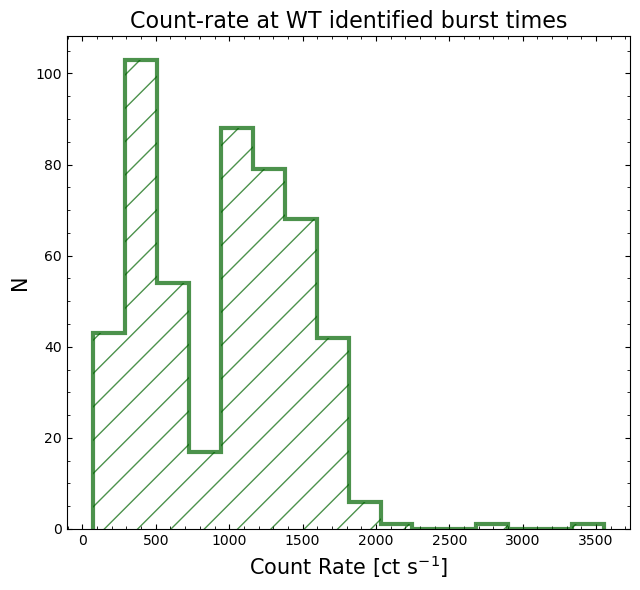

In [63]:
plt.figure(figsize=(6.5, 6))
plt.minorticks_on()
plt.tick_params(which="both", direction="in", top=True, right=True)

plt.hist(
    wt_agg_lc_demo_burst_res["burst_cr"].values,
    histtype="step",
    color="darkgreen",
    alpha=0.7,
    bins="auto",
    lw=3,
    hatch=r"/",
)

plt.xlabel(r"Count Rate [ct s$^{-1}$]", fontsize=15)
plt.ylabel("N", fontsize=15)

plt.title("Count-rate at WT identified burst times", fontsize=16)

plt.tight_layout()
plt.show()

#### Hardness ratios at potential burst times

Given the different astrophysical processes that appear to be driving the persistent and bursting X-ray
emission by T5X2, it would also be interesting to look at the hardness ratio of the emission
at the potential burst times.

We discussed hardness ratios in the previous section, calculating and visualizing a 'hardness curve' from our
newly generated custom-energy-band light curves. Here we will pull in the unique information that
those light curves contain to help paint a picture of what T5X2 might be doing.

Unfortunately, we were only able to generate light curves within specific energy bands with a time resolution
of 16 seconds. This is a hard limitation of the RXTE-PCA instrument, as the 'Standard-1' data mode we
used to make our high-time-resolution (two-second time bin in this case) contains no spectral information at all.

To determine the hardness ratio at our potential burst times, we will have to compromise and interpolate
the much coarser 16-second binning of the hardness curve to our peak detection times. Doing this without
further thought is acceptable because this is a demonstration, but you should consider the potential
measurement effects interpolation could produce for your own science case.

Once again, using the **2–10** keV light curves as the soft band, and the **10–30** keV as the
hard band, we interpolate the hardness ratio at every time step of the **two-second** time resolution
light curves. Then the interpolated hardness ratio at the time of each potential burst is extracted:

In [64]:
lo_en_demo_agg_data = agg_gen_en_bnd_lcs["2.0-10.0keV"].get_data()
lo_en_demo_agg_cr = lo_en_demo_agg_data[0]
lo_en_demo_agg_time = lo_en_demo_agg_data[2]

hi_en_demo_agg_data = agg_gen_en_bnd_lcs["10.0-30.0keV"].get_data()
hi_en_demo_agg_cr = hi_en_demo_agg_data[0]
hi_en_demo_agg_time = hi_en_demo_agg_data[2]

# Calculate the hardness ratio for all data points in the 16-second time bin
#  custom-energy-band light curves
agg_lc_hard_rat = (hi_en_demo_agg_cr - lo_en_demo_agg_cr) / (
    hi_en_demo_agg_cr + lo_en_demo_agg_cr
)

# Now we interpolate the hardness curve onto the time grid of the high-time
#  resolution light curve
wt_agg_lc_demo_interp_hard = np.interp(
    wt_agg_demo_time, lo_en_demo_agg_time, agg_lc_hard_rat
)

wt_agg_lc_demo_burst_hard = wt_agg_lc_demo_interp_hard[wt_agg_lc_demo_bursts]
wt_agg_lc_demo_burst_hard

<Quantity [-0.38279584, -0.38028888, -0.57576907, -0.56940712, -0.44229032,
           -0.45344542, -0.43152152, -0.42641755, -0.42785155, -0.4255084 ,
           -0.42716693, -0.43096786, -0.4527709 , -0.53481831, -0.536008  ,
           -0.4092487 , -0.44007717, -0.4006803 , -0.38486207, -0.41294915,
           -0.51428838, -0.52460744, -0.34385408, -0.19427114, -0.1823695 ,
           -0.15730013, -0.14419351, -0.33324543, -0.31540548, -0.37737559,
           -0.15106129, -0.26365138, -0.24205056, -0.2185293 , -0.32560381,
           -0.58743578, -0.59528232, -0.53016584, -0.53314585, -0.4427478 ,
           -0.44599309, -0.4393703 , -0.44789335, -0.44338343, -0.45706425,
           -0.4386022 , -0.44052269, -0.46397462, -0.55614012, -0.55176259,
           -0.45206688, -0.6149955 , -0.61322858, -0.47164627, -0.46876254,
           -0.45851579, -0.47960428, -0.37687463, -0.36587278, -0.40635983,
           -0.5381248 , -0.52638135, -0.51093889, -0.46040357, -0.34147806,
           -

For later ease of access, we add the interpolated hardness ratios at burst times to the
peak information dataframe we created earlier:

In [65]:
wt_agg_lc_demo_burst_res["interp_hardness"] = wt_agg_lc_demo_burst_hard
wt_agg_lc_demo_burst_res

time_chunk_id             burst_datetime        burst_time     burst_cr  \
0               0 2000-07-13 04:45:11.562431  206081055.378431   223.060604   
1               0 2000-07-13 04:55:33.562431  206081677.378431   331.641458   
2               0 2000-07-13 05:03:45.562431  206082169.378431   1088.23267   
3               0 2000-07-13 05:03:47.562431  206082171.378431   902.114175   
4               1 2000-07-13 17:57:31.562431  206128595.378431   379.813874   
..            ...                        ...               ...          ...   
498            57 2010-10-18 15:45:53.562429  530034299.378429  1710.659429   
499            57 2010-10-18 15:56:59.562429  530034965.378429  1698.160325   
500            57 2010-10-18 16:00:37.562429  530035183.378429  1681.672984   
501            57 2010-10-18 16:10:25.562429  530035771.378429  1504.303014   
502            57 2010-10-18 16:10:31.562429  530035777.378429  1538.253902   

    burst_cr_err  interp_hardness  
0      11.389885        -0.382796  
1      13.629187        -0.380289  
2      24.031044        -0.575769  
3      21.919986        -0.569407  
4      14.583534        -0.442290  
..           ...              ...  
498    30.096882        -0.754274  
499    29.972881        -0.749908  
500    29.845354        -0.754383  
501    28.374562        -0.753365  
502    28.673094        -0.755187  

[503 rows x 6 columns]

Now that hardness ratios at potential burst times have been calculated, we
can plot their distribution (just as we did for count-rate), as well as how they
compare to the count-rate at the time of each potential burst.

We also include the relationship between the count-rate and interpolated ratio for
**every** data point in the two-second time-resolution aggregated light
curve (right hand panel), to give us an idea of their overall relationship.

There appear to be at least two distinct populations of bursts, in terms of their
hardness ratio; one with a median hardness of ~-0.5, and another, softer, population
with a median hardness of ~-0.75.

The relationship of potential burst hardness to count-rate is also interesting, with a
complex morphology that could be due to at least two different processes driving the
persistent and bursting X-ray emission by T5X2. The softer (more negative hardness
ratio) bursts appear to have a minimal dependence on the count rate, whereas the harder
segment of the hardness ratio distribution seems to become softer with increasing count rate.

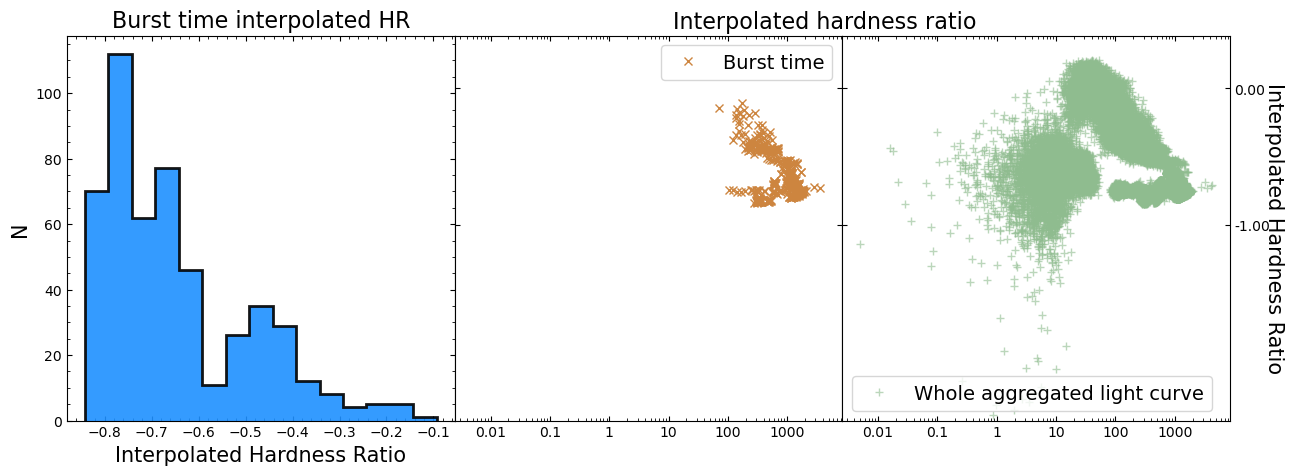

In [66]:
hr_step = 0.05
interp_hr_bins = np.arange(
    wt_agg_lc_demo_burst_hard.min(),
    wt_agg_lc_demo_burst_hard.max() + hr_step,
    hr_step,
)

fig, ax_arr = plt.subplots(ncols=3, figsize=(15, 5))
fig.subplots_adjust(wspace=0)

for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in", top=True, right=True)

ax = ax_arr[0]
ax.hist(
    wt_agg_lc_demo_burst_hard,
    histtype="step",
    ec="black",
    lw=2,
    alpha=0.9,
    bins=interp_hr_bins,
    fill=True,
    fc="dodgerblue",
)

ax.set_xlabel(r"Interpolated Hardness Ratio", fontsize=15)
ax.set_ylabel("N", fontsize=15)

ax.set_title("Burst time interpolated HR", fontsize=16)

last_ax = ax_arr[2]
mid_ax = ax_arr[1]

last_ax.plot(
    wt_agg_demo_cr,
    wt_agg_lc_demo_interp_hard,
    "+",
    color="darkseagreen",
    alpha=0.6,
    label="Whole aggregated light curve",
)
last_ax.sharey(mid_ax)
last_ax.sharex(mid_ax)
last_ax.legend(fontsize=14)

mid_ax.plot(
    wt_agg_lc_demo_burst_res["burst_cr"],
    wt_agg_lc_demo_burst_hard,
    "x",
    color="peru",
    label="Burst time",
)

mid_ax.legend(fontsize=14)

last_ax.set_xscale("log")
last_ax.set_yscale("symlog")

mid_ax.set_xscale("log")
mid_ax.set_yscale("symlog")

last_ax.yaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:.2f}".format(inp)))
last_ax.xaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))

mid_ax.yaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:.2f}".format(inp)))
mid_ax.xaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:g}".format(inp)))

last_ax.yaxis.set_ticks_position("right")
mid_ax.tick_params(labelleft=False)

plt.suptitle(r"Count Rate (2-60 keV) [ct s$^{-1}$]", x=0.63, y=0.07, fontsize=15)

last_ax.yaxis.set_label_position("right")
last_ax.set_ylabel(
    r"Interpolated Hardness Ratio", fontsize=15, rotation=-90, labelpad=10
)

plt.suptitle("Interpolated hardness ratio", x=0.63, y=0.93, fontsize=16)

mid_ax.tick_params(which="both", axis="y", direction="in", left=True, right=True)
last_ax.tick_params(which="both", axis="y", direction="in", left=True, right=True)

plt.show()

#### Visualizing light curves of potential bursts with hardness information

We can also plot some of the light curves, with potential burst times highlighted, and
include the interpolated hardness of the emission at burst time, to place the
hardness information in context.

A subset of light curves is selected, chosen to show some interesting features and
highlight the performance of the peak-finding algorithm.

As the light curves will be plotted on separate figures, but we want a consistent hardness
color scale throughout, we set up a matplotlib color mapper that will take a hardness
ratio value and return a color. It is normalized using the minimum and maximum burst
hardness ratios of all the selected light curves.

In [67]:
burst_sel_mask = wt_agg_lc_demo_burst_res["time_chunk_id"] > 45
subset_wt_agg_lc_demo_burst_res = wt_agg_lc_demo_burst_res[burst_sel_mask]
subset_wt_agg_interp_burst_hardness = wt_agg_lc_demo_burst_hard[burst_sel_mask]

# We want to normalise this colourmap to our specific data range
norm = Normalize(
    vmin=subset_wt_agg_interp_burst_hardness.min(),
    vmax=subset_wt_agg_interp_burst_hardness.max(),
)
# Now a mapper can be constructed so that we can take that information about
#  the cmap and normalisation and use it with our data to calculate colours
cmap_mapper = cm.ScalarMappable(norm=norm, cmap="turbo")
# This calculates the colours
colours = cmap_mapper.to_rgba(subset_wt_agg_interp_burst_hardness)

Now we plot the selected light curves, with vertical lines indicating a potential
burst, and the color of the line communicating the interpolated hardness ratio:

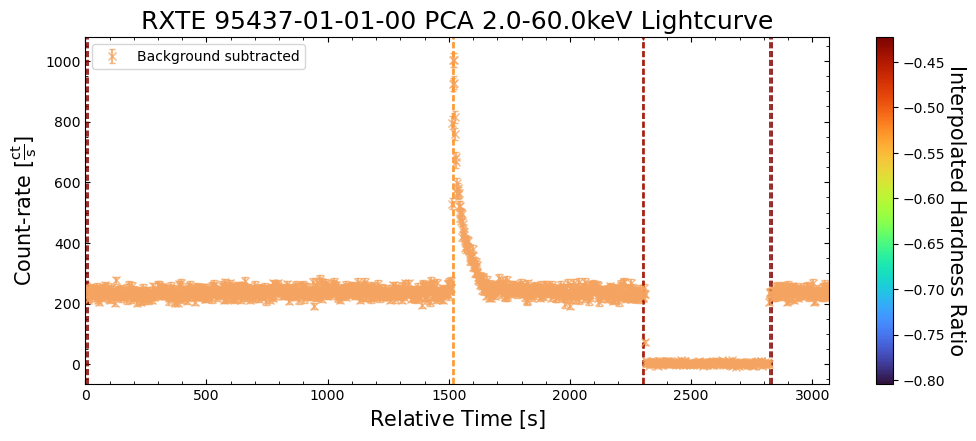

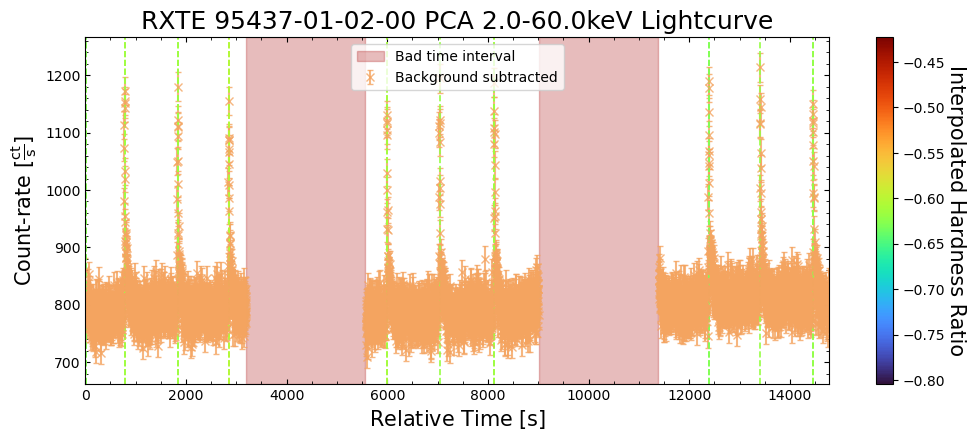

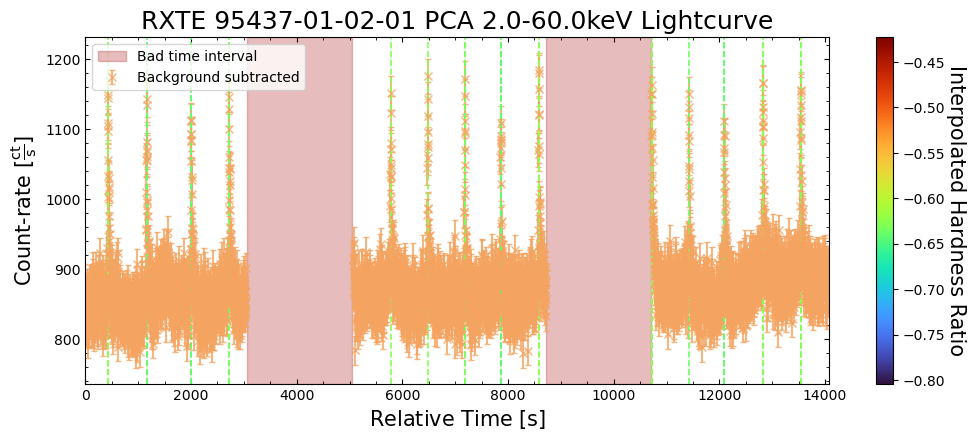

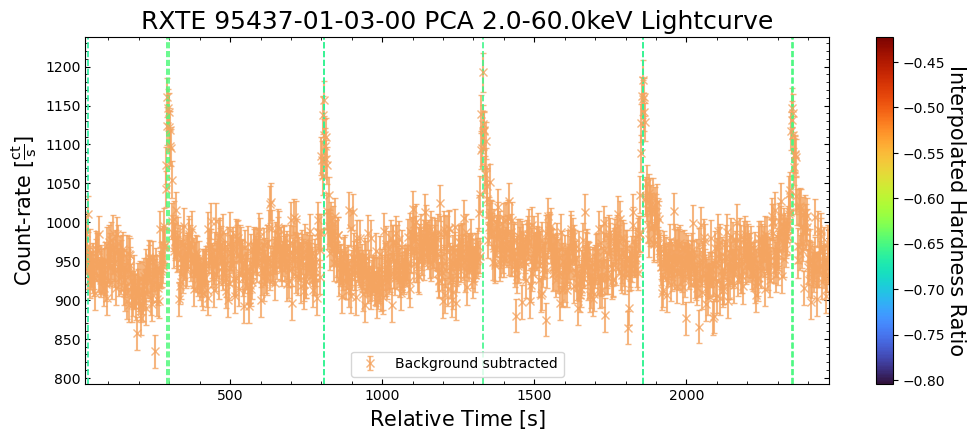

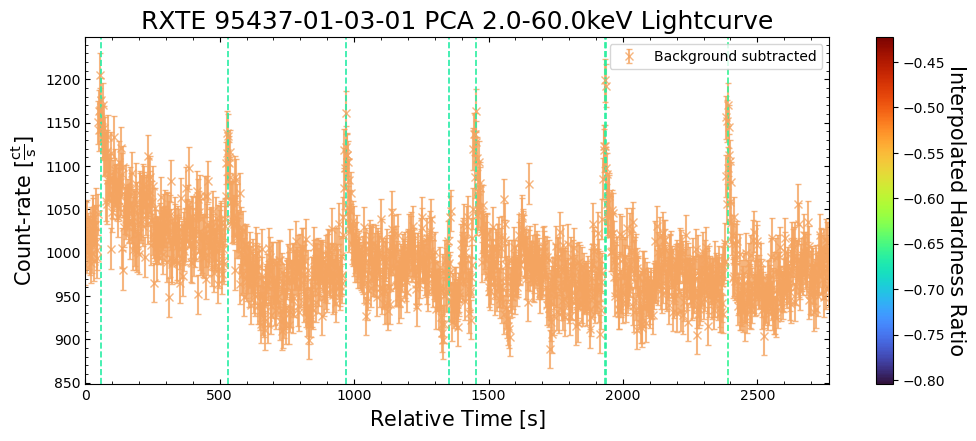

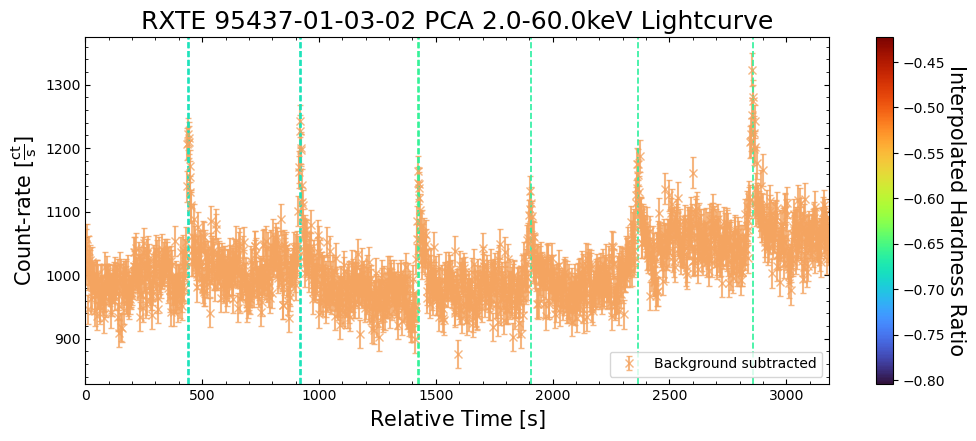

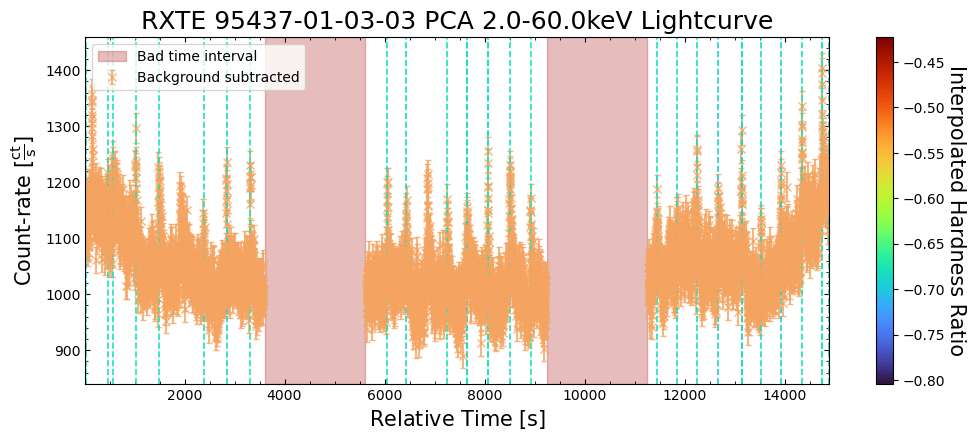

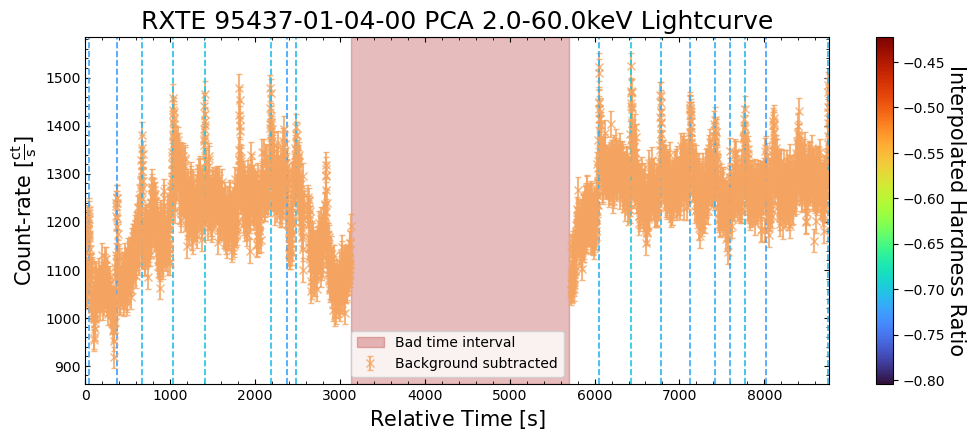

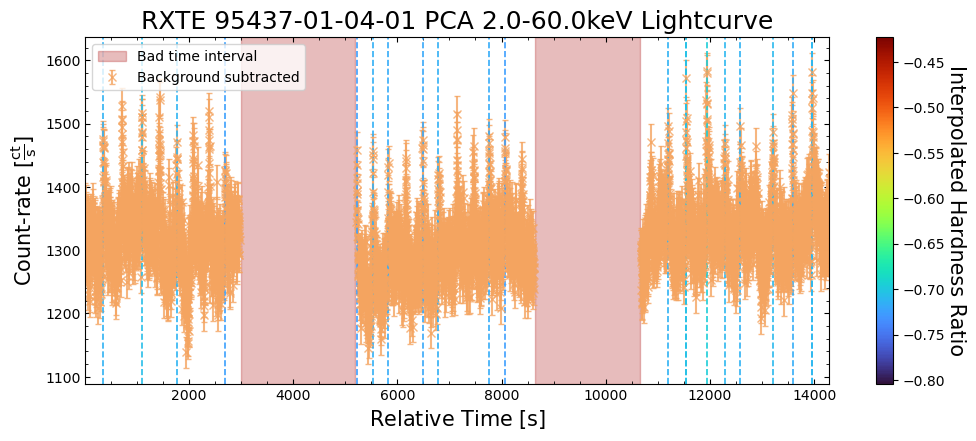

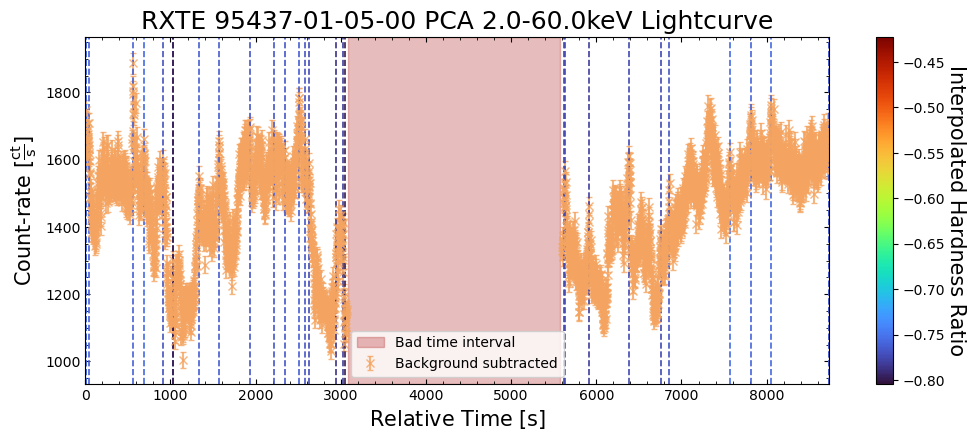

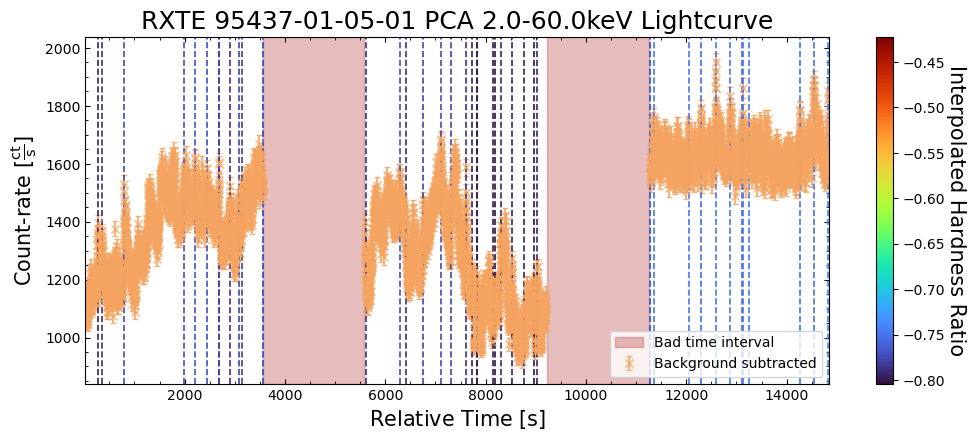

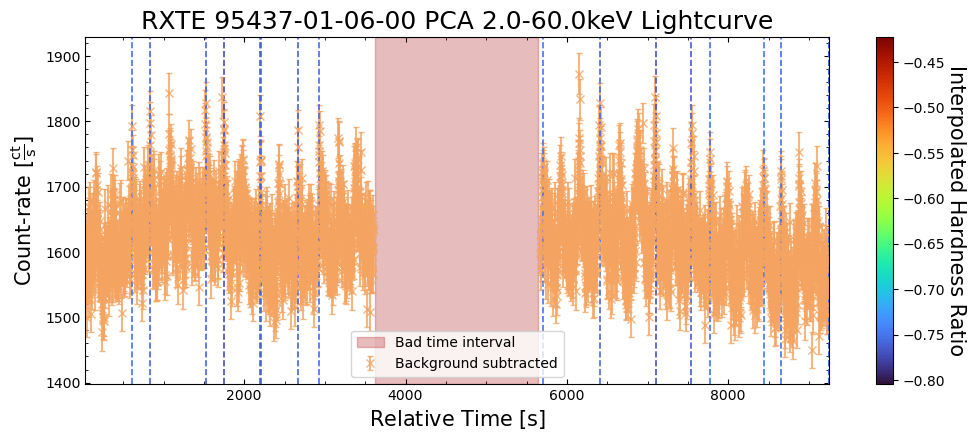

In [68]:
for cur_tc_id in subset_wt_agg_lc_demo_burst_res["time_chunk_id"].unique():
    cur_lc = burst_id_demo_agg_lc.get_lightcurves(cur_tc_id)
    sel_bursts = subset_wt_agg_lc_demo_burst_res[
        subset_wt_agg_lc_demo_burst_res["time_chunk_id"] == cur_tc_id
    ]

    cur_burst_times = sel_bursts["burst_time"].values
    cur_burst_colors = colours[
        subset_wt_agg_lc_demo_burst_res["time_chunk_id"] == cur_tc_id
    ]

    # Set up a figure, specifying the size
    plt.figure(figsize=(12, 4.5))
    # Fetch the axis that was created along with it, so it can be passed to get_view()
    ax = plt.gca()

    # This will populate the axis so that it looks like the visualisations
    #  we've been looking at
    ax = cur_lc.get_view(ax, "s", colour="sandybrown")

    # Iterate through the possible peaks, and add them to our retrieved, populated, axes
    for b_time_ind, b_time in enumerate(cur_burst_times):
        b_time = b_time - cur_lc.start_time.to("s").value
        plt.axvline(
            b_time,
            color=cur_burst_colors[b_time_ind],
            linestyle="dashed",
            linewidth=1.2,
        )

    cbar = plt.colorbar(cmap_mapper, ax=ax)
    cbar.set_label(
        "Interpolated Hardness Ratio", fontsize=15, rotation=-90, labelpad=15
    )

    plt.show()

### Number and frequency of potential bursts

The number of bursts per unit time is another quantity that might be interesting
to look at, as there are several potential questions it might answer. For instance:

Does the burst frequency stay constant across our observations of T5X2, or does
it increase as we move into the phase of a continuous process increasing the base
emission of T5X2?

As it seems there might be two distinct populations of bursts (in terms of their
hardness ratio, and its relationship to count-rate), does the frequency of soft
and hard bursts change over the course of our observations?

We can use our peak-finding results, alongside information extracted from the light curves, to
get an idea of the potential burst frequency.

#### How many peaks did we find in each time chunk?

To calculate the burst frequency, we need to start by determining how many bursts were
identified during each 'time chunk' of our aggregated light curve.

This is made easy by our previous decision to store the burst information in
a Pandas dataframe. We can use the `value_counts()` method of "time_chunk_id"
column to count how many times each unique time chunk ID appears in that
column (recall that every row represents a potential burst).

The output of this is a Pandas `Series` with "time_chunk_id" index values and the number
of bursts with that time chunk ID as values.

We then order the series from lowest to highest time chunk ID:

In [69]:
burst_per_chunk = wt_agg_lc_demo_burst_res["time_chunk_id"].value_counts()
burst_per_chunk = burst_per_chunk.sort_index()
burst_per_chunk.index = burst_per_chunk.index.astype(int)
burst_per_chunk

time_chunk_id
0      4
1      8
2      1
3      7
4     13
5      2
6      2
7      2
8     11
9      7
10    18
11    21
12     6
13     5
14     4
15    13
16     7
17     2
18     7
19    17
20     4
21     9
22     3
23     5
25    13
26     3
27     5
30     5
31     2
33     1
34     2
43    13
44    45
46     8
47    18
48    26
49    10
50     8
51     9
52    29
53    17
54    21
55    30
56    43
57    17
Name: count, dtype: int64

The number of bursts detected per time chunk varies significantly, with some time
chunk IDs not even represented in the dataframe (meaning no peaks were detected).

We cannot draw too many conclusions from this yet, though, as the time chunks are
not guaranteed to be of equal length. Our next step has to be to calculate the
number of bursts per second for each time chunk.

#### Calculating the frequency of bursts

In order to calculate the frequency of burst occurrence, we need to know the length
of time represented by each time chunk. This is easy to extract (using
the `time_chunk_lengths` property) from the two-second time resolution
AggregateLightCurve object we set up earlier, when we generated those light curves.

Knowing the lengths of time chunks isn't enough by itself, though, as there is no guarantee that
we have data for the entire time period covered by a particular time chunk. Perhaps there
were issues with the detector, or the data from part of the observation did not pass our
screening criteria - either way, we can't include such time periods, as we may
underestimate the burst frequency.

The good-time-intervals of each light curve (GTIs) will tell us whether there are any
time periods that we shouldn't include in our total time chunk length determination.
GTI information is loaded in from light curve files, if available, and can again be
accessed through the AggregateLightCurve object.

In this instance, we can use the `time_chunk_good_fractions()` method of AggregateLightCurve to
retrieve the fraction of each time chunk that is within the GTIs of its light curve.

Multiplying the time chunk lengths by this fraction will give us the **actual** length
of time we should divide the number of bursts by to get the burst frequency:

In [70]:
time_chunk_size = (
    burst_id_demo_agg_lc.time_chunk_lengths
    * burst_id_demo_agg_lc.time_chunk_good_fractions()
)

time_chunk_peak_freq = np.zeros(time_chunk_size.shape)
time_chunk_peak_freq[burst_per_chunk.index.values] = (
    burst_per_chunk.values / time_chunk_size[burst_per_chunk.index.values]
)

time_chunk_peak_freq

array([0.00246305, 0.00462963, 0.00099602, 0.00209205, 0.00377468,
       0.00068823, 0.00058997, 0.00084674, 0.00308989, 0.00202781,
       0.005625  , 0.00469379, 0.00129983, 0.00261233, 0.00208333,
       0.00102783, 0.00197294, 0.00104167, 0.00368809, 0.00332811,
       0.00294551, 0.00439453, 0.00089874, 0.00163613, 0.        ,
       0.00380117, 0.00086856, 0.00092353, 0.        , 0.        ,
       0.00216076, 0.00074405, 0.        , 0.00041118, 0.00067935,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03494624, 0.01365291,
       0.        , 0.00260417, 0.00178678, 0.00257426, 0.00400641,
       0.002886  , 0.00281955, 0.00266055, 0.00274194, 0.00207428,
       0.00479386, 0.00397559, 0.00235066])

We can now plot the overall distribution of peak detection (which is hopefully
correlated with burst) frequencies. The majority of our time chunks appear to not have
any bursts detected, which could be a real finding, or a limitation of the automatic
peak-finding algorithm/configuration.

Disregarding those with zero bursts, the distribution of peak detection frequency
peaks at around 0.003 Hz, or 3 bursts per kilosecond. We also note the presence of some
outliers with much higher peak detection frequencies.

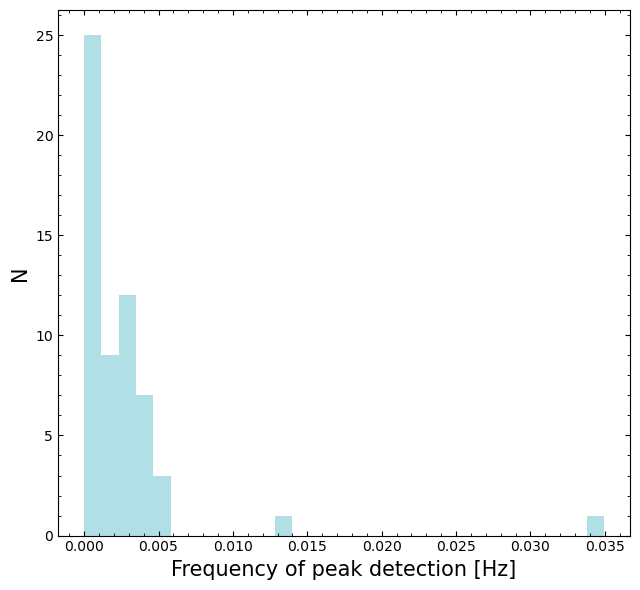

In [71]:
plt.figure(figsize=(6.5, 6))
plt.minorticks_on()
plt.tick_params(which="both", direction="in", top=True, right=True)

plt.hist(time_chunk_peak_freq, bins=30, color="powderblue")

plt.ylabel("N", fontsize=15)
plt.xlabel("Frequency of peak detection [Hz]", fontsize=15)

plt.tight_layout()
plt.show()

#### Does the frequency of peak identification evolve with time?

We have the frequency of peak detection for each time chunk, and so we can plot it
against the time chunk central time in order to see if the peak detection frequency
changes over the course of our observations.

First, we calculate the time chunk central times, using Python datetime objects because
matplotlib can be easily configured to display datetimes as axis labels:

In [72]:
datetime_chunk_halfwidths = (
    np.diff(burst_id_demo_agg_lc.datetime_chunks, axis=1).flatten() / 2
)
datetime_chunk_centers = (
    burst_id_demo_agg_lc.datetime_chunks[:, 0] + datetime_chunk_halfwidths
)

Then we can make the figure! As we are covering a time period of nearly ten years, and
we are using a continuous x-axis, the data points are very close together and somewhat
hard to interpret. As such, we include inset zooms into time-periods of interest.

We don't see a dramatic difference in the peak detection frequencies at different times, though the
frequencies on the right-hand side of the plot, from 2010, seem to have more consistent
peak detection frequencies than those from 2001.

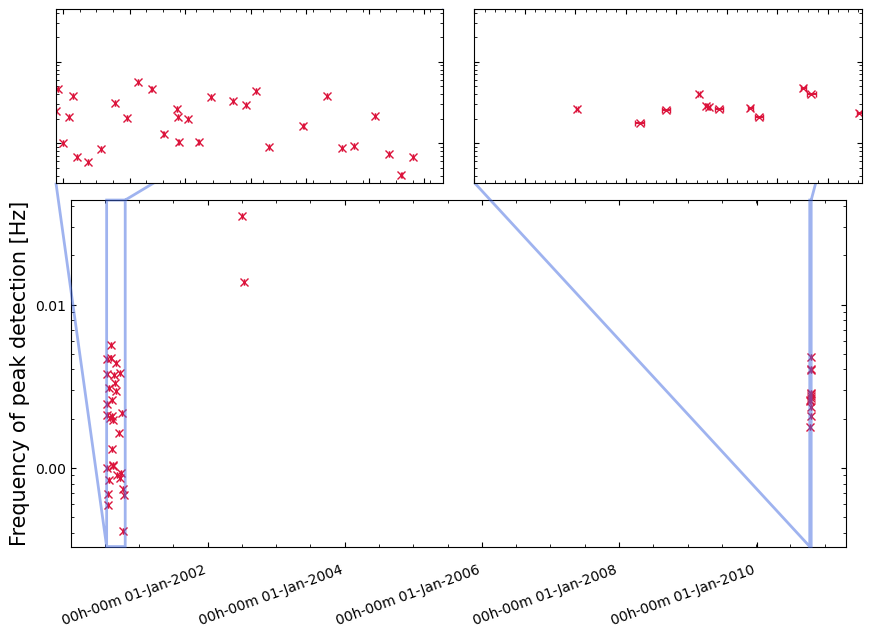

In [73]:
plt.figure(figsize=(10, 4.5))
ax = plt.gca()

plt.minorticks_on()
plt.tick_params(which="both", direction="in", top=True, right=True)

plt.errorbar(
    datetime_chunk_centers,
    time_chunk_peak_freq,
    xerr=datetime_chunk_halfwidths,
    fmt="x",
    capsize=2,
    color="crimson",
)

# The x-axis data were in the form of datetimes, and we can use a matplotlib
#  formatted to ensure that the tick labels are displayed correctly
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Hh-%Mm %d-%b-%Y"))
# We also rotate the tick labels to make them easier to read
for label in ax.get_xticklabels(which="major"):
    label.set(
        y=label.get_position()[1] - 0.03, rotation=20, horizontalalignment="right"
    )

plt.yscale("log")
ax.yaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:.2f}".format(inp)))
plt.ylabel("Frequency of peak detection [Hz]", fontsize=15)

# ----------- INSET ONE -----------

inset_one_low_lim = burst_id_demo_agg_lc.datetime_chunks.min()
inset_one_upp_lim = Time("2000-10-20").datetime

axins_one = ax.inset_axes(
    [-0.02, 1.05, 0.5, 0.5], ylim=plt.ylim(), xticklabels=[], yticklabels=[]
)
# Configure the ticks on the new axis
axins_one.minorticks_on()
axins_one.tick_params(which="both", direction="in", top=True, right=True)

# Have to replot the light curve data on the inset axis
axins_one.errorbar(
    datetime_chunk_centers,
    time_chunk_peak_freq,
    xerr=datetime_chunk_halfwidths,
    fmt="x",
    capsize=2,
    color="crimson",
)
# Setting the time range of the zoomed view
axins_one.set_xlim(inset_one_low_lim, inset_one_upp_lim)

axins_one.set_yscale("log")
axins_one.set_yticklabels([])
ax.indicate_inset_zoom(axins_one, edgecolor="royalblue", lw=2)

# ----------- INSET TWO -----------

inset_two_low_lim = Time("2010-10-11").datetime
inset_two_upp_lim = burst_id_demo_agg_lc.datetime_chunks.max()

axins_two = ax.inset_axes(
    [0.52, 1.05, 0.5, 0.5], ylim=plt.ylim(), xticklabels=[], yticklabels=[]
)
# Configure the ticks on the new axis
axins_two.minorticks_on()
axins_two.tick_params(which="both", direction="in", top=True, right=True)

# Have to replot the light curve data on the inset axis
axins_two.errorbar(
    datetime_chunk_centers,
    time_chunk_peak_freq,
    xerr=datetime_chunk_halfwidths,
    fmt="x",
    capsize=2,
    color="crimson",
)
# Setting the time range of the zoomed view
axins_two.set_xlim(inset_two_low_lim, inset_two_upp_lim)

axins_two.set_yscale("log")
axins_two.set_yticklabels([])
ax.indicate_inset_zoom(axins_two, edgecolor="royalblue", lw=2)

plt.show()

#### Does the hardness ratio of potential bursts evolve with time?

Considering that we may have identified two populations of bursts with
different hardness ratios, we can attempt to see if the occurrence frequency of
'softer' and 'harder' bursts changes over the course of our observations.

Based on the potential burst hardness ratio distribution visualization we created earlier, we choose
a boundary of -0.6 to split the bursts into 'softer' (less than -0.6) and 'harder' (greater than -0.6) groups.

We follow the same procedure as before to calculate the potential burst frequency, first for the 'harder' bursts:

In [74]:
hard_burst_res = wt_agg_lc_demo_burst_res[
    wt_agg_lc_demo_burst_res["interp_hardness"] >= -0.6
]
hard_burst_per_chunk = hard_burst_res["time_chunk_id"].value_counts()
hard_burst_per_chunk = hard_burst_per_chunk.sort_index()
hard_burst_per_chunk.index = hard_burst_per_chunk.index.astype(int)

time_chunk_hard_peak_freq = np.zeros(time_chunk_size.shape)
time_chunk_hard_peak_freq[hard_burst_per_chunk.index.values] = (
    hard_burst_per_chunk.values / time_chunk_size[hard_burst_per_chunk.index.values]
)

Then for the 'softer' bursts:

In [75]:
soft_burst_res = wt_agg_lc_demo_burst_res[
    wt_agg_lc_demo_burst_res["interp_hardness"] < -0.6
]
soft_burst_per_chunk = soft_burst_res["time_chunk_id"].value_counts()
soft_burst_per_chunk = soft_burst_per_chunk.sort_index()
soft_burst_per_chunk.index = soft_burst_per_chunk.index.astype(int)

time_chunk_soft_peak_freq = np.zeros(time_chunk_size.shape)
time_chunk_soft_peak_freq[soft_burst_per_chunk.index.values] = (
    soft_burst_per_chunk.values / time_chunk_size[soft_burst_per_chunk.index.values]
)

The distributions of potential burst frequency for the softer and harder bursts seem
fairly similar:

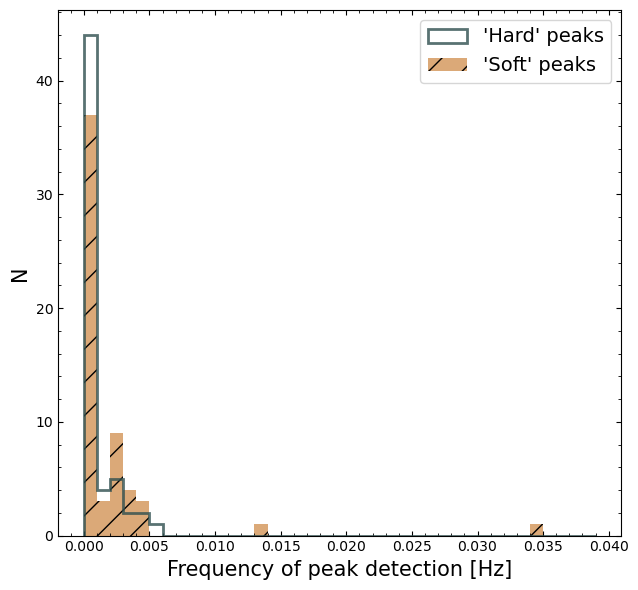

In [76]:
freq_bins = np.arange(0, 0.04, 0.001)

plt.figure(figsize=(6.5, 6))
plt.minorticks_on()
plt.tick_params(which="both", direction="in", top=True, right=True)

plt.hist(
    time_chunk_hard_peak_freq,
    bins=freq_bins,
    color="darkslategray",
    histtype="step",
    lw=2,
    label="'Hard' peaks",
    density=False,
    alpha=0.8,
)
plt.hist(
    time_chunk_soft_peak_freq,
    bins=freq_bins,
    color="peru",
    histtype="stepfilled",
    hatch="/",
    label="'Soft' peaks",
    density=False,
    alpha=0.7,
)

plt.ylabel("N", fontsize=15)
plt.xlabel("Frequency of peak detection [Hz]", fontsize=15)

plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

When we view the 'harder' and 'softer' burst frequencies as a function of time,
however, we see a stark division between the two sets of frequencies on the plot.

We observe that most of the time chunks with a non-zero 'hard' (>-0.6) burst frequency
have a 'soft' (<=-0.6) burst frequency of zero, and vice versa.

Not only that, but most of the non-zero **'hard'** burst frequencies are found in the
earliest observations, and then most of the subsequent time chunks only have
non-zero **'soft'** burst frequencies.

This may indicate that there **is** an evolution of the burst hardness ratio over
time, though more exploration of the data, the techniques we use, and the choice of
'hardness' boundary would be required to confidently state this.

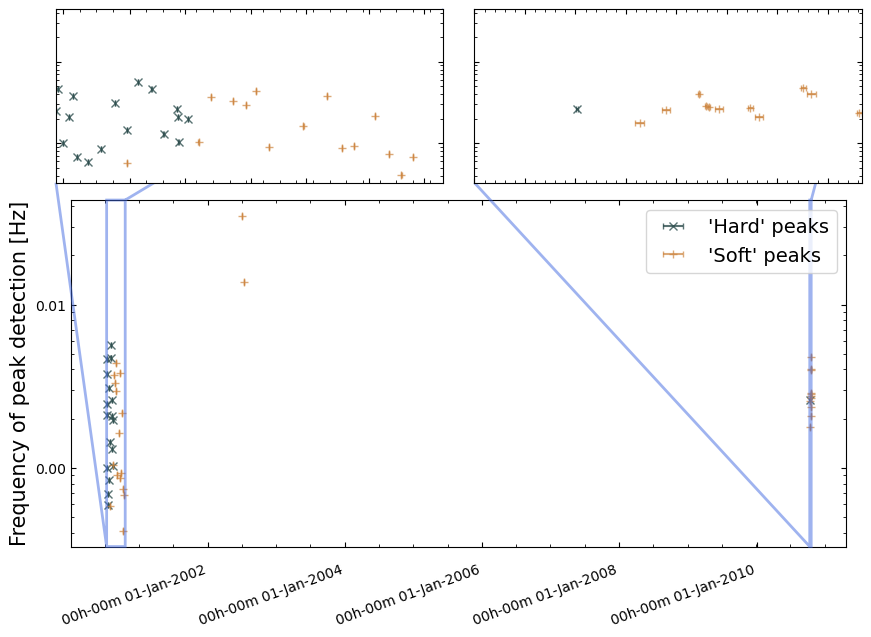

In [77]:
plt.figure(figsize=(10, 4.5))
ax = plt.gca()

plt.minorticks_on()
plt.tick_params(which="both", direction="in", top=True, right=True)

plt.errorbar(
    datetime_chunk_centers,
    time_chunk_hard_peak_freq,
    xerr=datetime_chunk_halfwidths,
    fmt="x",
    capsize=2,
    color="darkslategray",
    alpha=0.8,
    label="'Hard' peaks",
)
plt.errorbar(
    datetime_chunk_centers,
    time_chunk_soft_peak_freq,
    xerr=datetime_chunk_halfwidths,
    fmt="+",
    capsize=2,
    color="peru",
    alpha=0.7,
    label="'Soft' peaks",
)

# The x-axis data were in the form of datetimes, and we can use a matplotlib
#  formatted to ensure that the tick labels are displayed correctly
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Hh-%Mm %d-%b-%Y"))
# We also rotate the tick labels to make them easier to read
for label in ax.get_xticklabels(which="major"):
    label.set(
        y=label.get_position()[1] - 0.03, rotation=20, horizontalalignment="right"
    )

plt.yscale("log")
ax.yaxis.set_major_formatter(FuncFormatter(lambda inp, _: "{:.2f}".format(inp)))
plt.ylabel("Frequency of peak detection [Hz]", fontsize=15)

plt.legend(fontsize=14)

# ----------- INSET ONE -----------

inset_one_low_lim = burst_id_demo_agg_lc.datetime_chunks.min()
inset_one_upp_lim = Time("2000-10-20").datetime

axins_one = ax.inset_axes(
    [-0.02, 1.05, 0.5, 0.5], ylim=plt.ylim(), xticklabels=[], yticklabels=[]
)
# Configure the ticks on the new axis
axins_one.minorticks_on()
axins_one.tick_params(which="both", direction="in", top=True, right=True)

# Have to replot the light curve data on the inset axis
axins_one.errorbar(
    datetime_chunk_centers,
    time_chunk_hard_peak_freq,
    xerr=datetime_chunk_halfwidths,
    fmt="x",
    capsize=2,
    color="darkslategray",
    alpha=0.8,
    label="'Hard' peaks",
)
axins_one.errorbar(
    datetime_chunk_centers,
    time_chunk_soft_peak_freq,
    xerr=datetime_chunk_halfwidths,
    fmt="+",
    capsize=2,
    color="peru",
    alpha=0.7,
    label="'Soft' peaks",
)
# Setting the time range of the zoomed view
axins_one.set_xlim(inset_one_low_lim, inset_one_upp_lim)

axins_one.set_yscale("log")
axins_one.set_yticklabels([])
ax.indicate_inset_zoom(axins_one, edgecolor="royalblue", lw=2)

# ----------- INSET TWO -----------

inset_two_low_lim = Time("2010-10-11").datetime
inset_two_upp_lim = burst_id_demo_agg_lc.datetime_chunks.max()

axins_two = ax.inset_axes(
    [0.52, 1.05, 0.5, 0.5], ylim=plt.ylim(), xticklabels=[], yticklabels=[]
)
# Configure the ticks on the new axis
axins_two.minorticks_on()
axins_two.tick_params(which="both", direction="in", top=True, right=True)

# Have to replot the light curve data on the inset axis
axins_two.errorbar(
    datetime_chunk_centers,
    time_chunk_hard_peak_freq,
    xerr=datetime_chunk_halfwidths,
    fmt="x",
    capsize=2,
    color="darkslategray",
    alpha=0.8,
    label="'Hard' peaks",
)
axins_two.errorbar(
    datetime_chunk_centers,
    time_chunk_soft_peak_freq,
    xerr=datetime_chunk_halfwidths,
    fmt="+",
    capsize=2,
    color="peru",
    alpha=0.7,
    label="'Soft' peaks",
)
# Setting the time range of the zoomed view
axins_two.set_xlim(inset_two_low_lim, inset_two_upp_lim)

axins_two.set_yscale("log")
axins_two.set_yticklabels([])
ax.indicate_inset_zoom(axins_two, edgecolor="royalblue", lw=2)

plt.show()

***


## About this notebook

Author: David J Turner, HEASARC Staff Scientist.

Author: Tess Jaffe, HEASARC Chief Archive Scientist.

Updated On: 2026-01-22

### Additional Resources

[HEASARC RXTE mission page](https://heasarc.gsfc.nasa.gov/docs/xte/rxte.html)

[NASA press release on RXTE observations of T5X2](https://www.nasa.gov/universe/nasas-rxte-captures-thermonuclear-behavior-of-unique-neutron-star/)

[HEASARC discussion of RXTE-PCA screening and filtering](https://heasarc.gsfc.nasa.gov/docs/xte/recipes2/Screening.html?QuickLinksMenu=/vo/)

[HEASARC RXTE-PCA energy-channel conversion table](https://heasarc.gsfc.nasa.gov/docs/xte/e-c_table.html)

[Chandra X-ray Center dictionary](https://cxc.cfa.harvard.edu/ciao/dictionary/hardness_ratio.html)

[Chandra Source Catalog Hardness Ratio](https://cxc.cfa.harvard.edu/csc/columns/spectral_properties.html)

### Acknowledgements


### References

[M. Linares et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012ApJ...748...82L/abstract) - _Millihertz Quasi-periodic Oscillations and Thermonuclear Bursts from Terzan 5: A Showcase of Burning Regimes_

[M. Maier et al. (2024)](https://www.tandfonline.com/doi/full/10.1080/17437199.2025.2513916) - _Systematic review of the effects of decision fatigue in healthcare professionals on medical decision-making_